<a href="https://colab.research.google.com/github/MeriemTerki/Store-Sales-by-time-series/blob/main/Store_Sales_by_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Context
Forecasts aren’t just for meteorologists. Governments forecast economic growth. Scientists attempt to predict the future population. And businesses forecast product demand—a common task of professional data scientists. Forecasts are especially relevant to brick-and-mortar grocery stores, which must dance delicately with how much inventory to buy. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leading to lost revenue and upset customers. More accurate forecasting, thanks to machine learning, could help ensure retailers please customers by having just enough of the right products at the right time.

Current subjective forecasting methods for retail have little data to back them up and are unlikely to be automated. The problem becomes even more complex as retailers add new locations with unique needs, new products, ever-transitioning seasonal tastes, and unpredictable product marketing.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
from warnings import simplefilter
simplefilter("ignore")  # ignore warnings to clean up output cells

import gc # for garbage cleaning

%config Completer.use_jedi = False # for autocomplete

In [ ]:
oil_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Projects/Store Sales by time series/oil.csv")
holiday_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Projects/Store Sales by time series/holidays_events.csv")
store_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Projects/Store Sales by time series/stores.csv")
train_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Projects/Store Sales by time series/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Projects/Store Sales by time series/test.csv")
transaction_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Projects/Store Sales by time series/transactions.csv")
sample = pd.read_csv("/content/drive/MyDrive/Machine Learning Projects/Store Sales by time series/sample_submission .csv")

In [ ]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [ ]:
sample.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [ ]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [ ]:
print('there are {} different product families'.format(train_data.family.nunique()))

there are 33 different product families


In [ ]:
print('there are {} different stores'.format(train_data.store_nbr.nunique()))

there are 54 different stores


In [ ]:
process_train = train_data.copy()

del train_data

process_train['date'] = pd.to_datetime(process_train['date'])
process_train = process_train.set_index('date')
process_train = process_train.drop('id',axis = 1)
process_train[['store_nbr','family']].astype('category') #to reduce ram usage
process_train

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0
2013-01-01,1,BABY CARE,0.000,0
2013-01-01,1,BEAUTY,0.000,0
2013-01-01,1,BEVERAGES,0.000,0
2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0
2017-08-15,9,PREPARED FOODS,154.553,1
2017-08-15,9,PRODUCE,2419.729,148


In [ ]:
process_train.isna().sum()

store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [ ]:
def count_day_gap(df):
    temp = df.reset_index().groupby(['date']).sales.sum()
    return (temp.index[1:]-temp.index[:-1]).value_counts()

In [ ]:
count_day_gap(process_train)

1 days    1679
2 days       4
Name: date, dtype: int64

In [ ]:
temp = process_train.reset_index().groupby(['date']).sales.sum().to_frame()
gap = (temp.index[1:]-temp.index[:-1]).to_list()
gap.insert(0,'first day') 
temp['gap'] = gap

day_skip = temp.groupby('gap').get_group(temp.gap.unique()[2])
day_skip

,sales,gap
date,,
2013-12-26,4.707312e+05,2 days 00:00:00
2014-12-26,8.720985e+05,2 days 00:00:00
2015-12-26,9.467252e+05,2 days 00:00:00
2016-12-26,1.032771e+06,2 days 00:00:00


In [ ]:
del temp

In [ ]:
process_train.groupby('date').sales.sum().sort_values().head(10)

date
2013-01-01      2511.618999
2014-01-01      8602.065404
2017-01-01     12082.500997
2015-01-01     12773.616980
2016-01-01     16433.394000
2013-01-24    247245.690995
2013-03-14    247541.420096
2013-01-10    258982.003049
2013-01-29    264488.818076
2013-06-27    266525.458966
Name: sales, dtype: float64

In [ ]:
date_fam_sale = process_train.groupby(['date','family']).sum().sales
unstack = date_fam_sale.unstack()
unstack = unstack.resample('1M').sum()

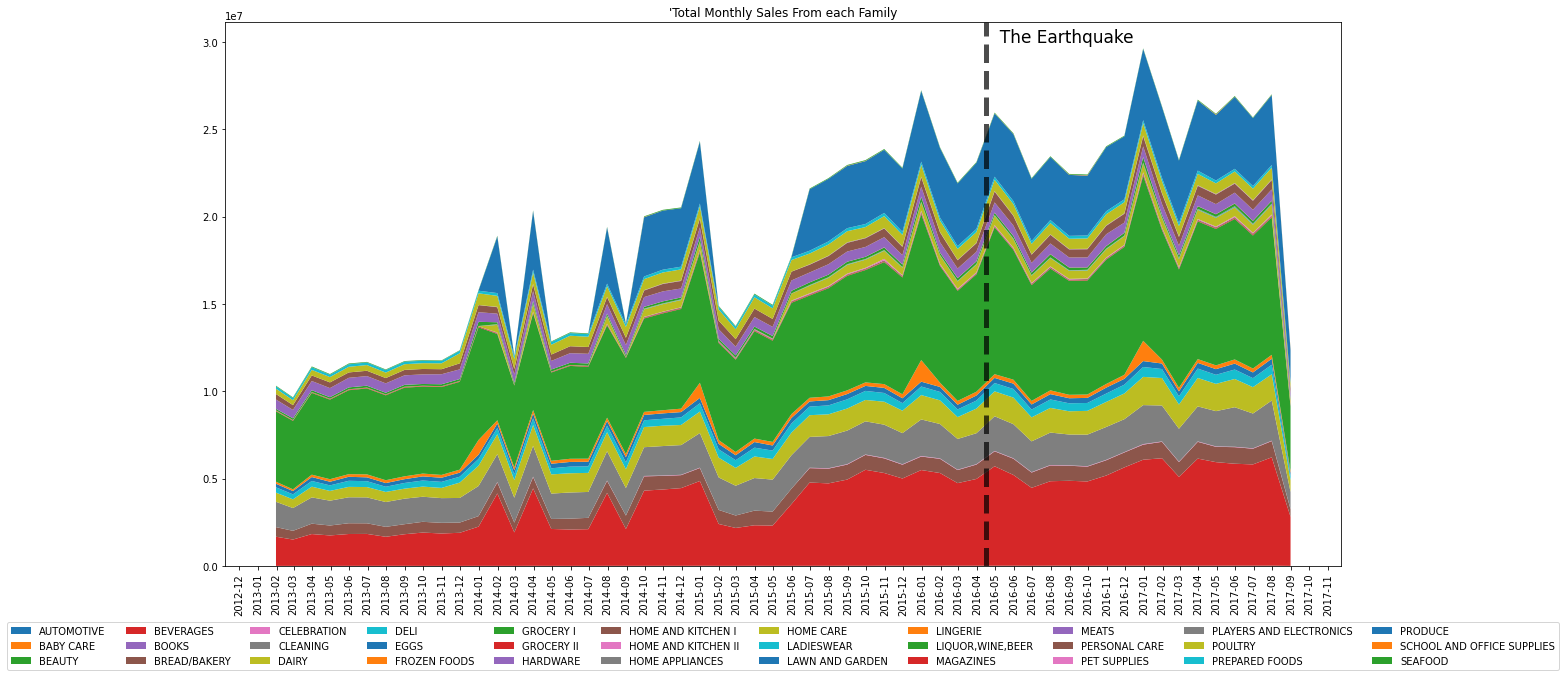

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set(title="'Total Monthly Sales From each Family")
plt.stackplot(unstack.index,unstack.T,labels=unstack.T.index)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.axvline(x=pd.Timestamp('2016-04-16'),color='black',linestyle='--',linewidth=5,alpha=0.7)
plt.text(pd.Timestamp('2016-04-20'),30000000,'  The Earthquake',rotation=360,c='black',size=17)
plt.xticks(rotation=90)
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-0.2),ncol=11)
plt.show()

In [ ]:
del unstack
del date_fam_sale

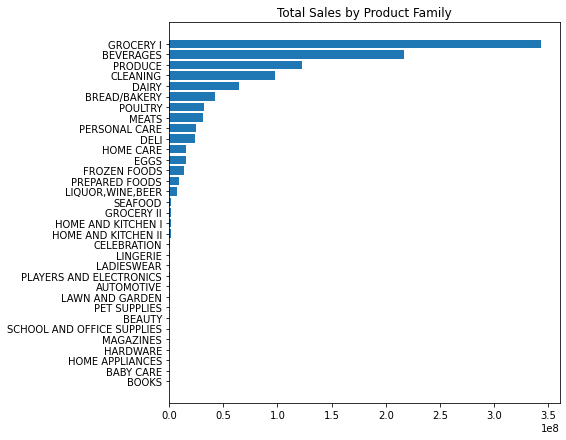

In [ ]:
month_family = process_train.groupby('family').resample('M').sales.sum()

fig, ax = plt.subplots(figsize=(7,7))
plt.barh(month_family.groupby('family').sum().sort_values().index,month_family.groupby('family').sum().sort_values())
ax.set(title='Total Sales by Product Family')
plt.show()

In [ ]:
total_sale = month_family.sum()
family_sale = month_family.groupby('family').sum().sort_values()
proportion = ((family_sale/total_sale)*100).sort_values(ascending=False)
proportion = pd.DataFrame(proportion)
proportion.head()

,sales
family,
GROCERY I,31.990346
BEVERAGES,20.207284
PRODUCE,11.428795
CLEANING,9.083197
DAIRY,6.006428


In [ ]:
del family_sale

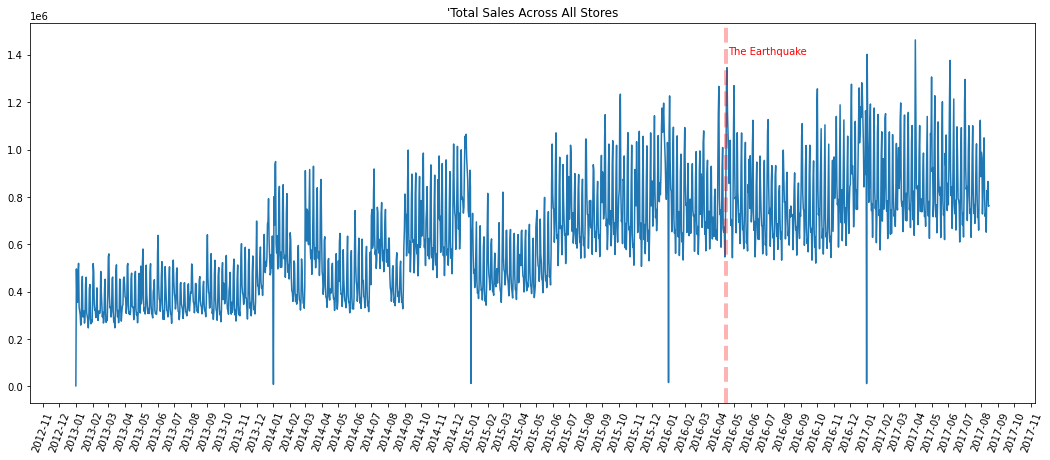

In [ ]:
fig, ax = plt.subplots(figsize=(18, 7))
ax.set(title="'Total Sales Across All Stores")
total_sales = process_train.sales.groupby("date").sum()
plt.plot(total_sales)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=70)
plt.axvline(x=pd.Timestamp('2016-04-16'),color='r',linestyle='--',linewidth=4,alpha=0.3)
plt.text(pd.Timestamp('2016-04-20'),1400000,'The Earthquake',rotation=360,c='r')


plt.show()

In [ ]:
daily_sale_dict = {}
for i in process_train.store_nbr.unique():
    daily_sale = process_train[process_train['store_nbr']==i]
    daily_sale_dict[i] = daily_sale

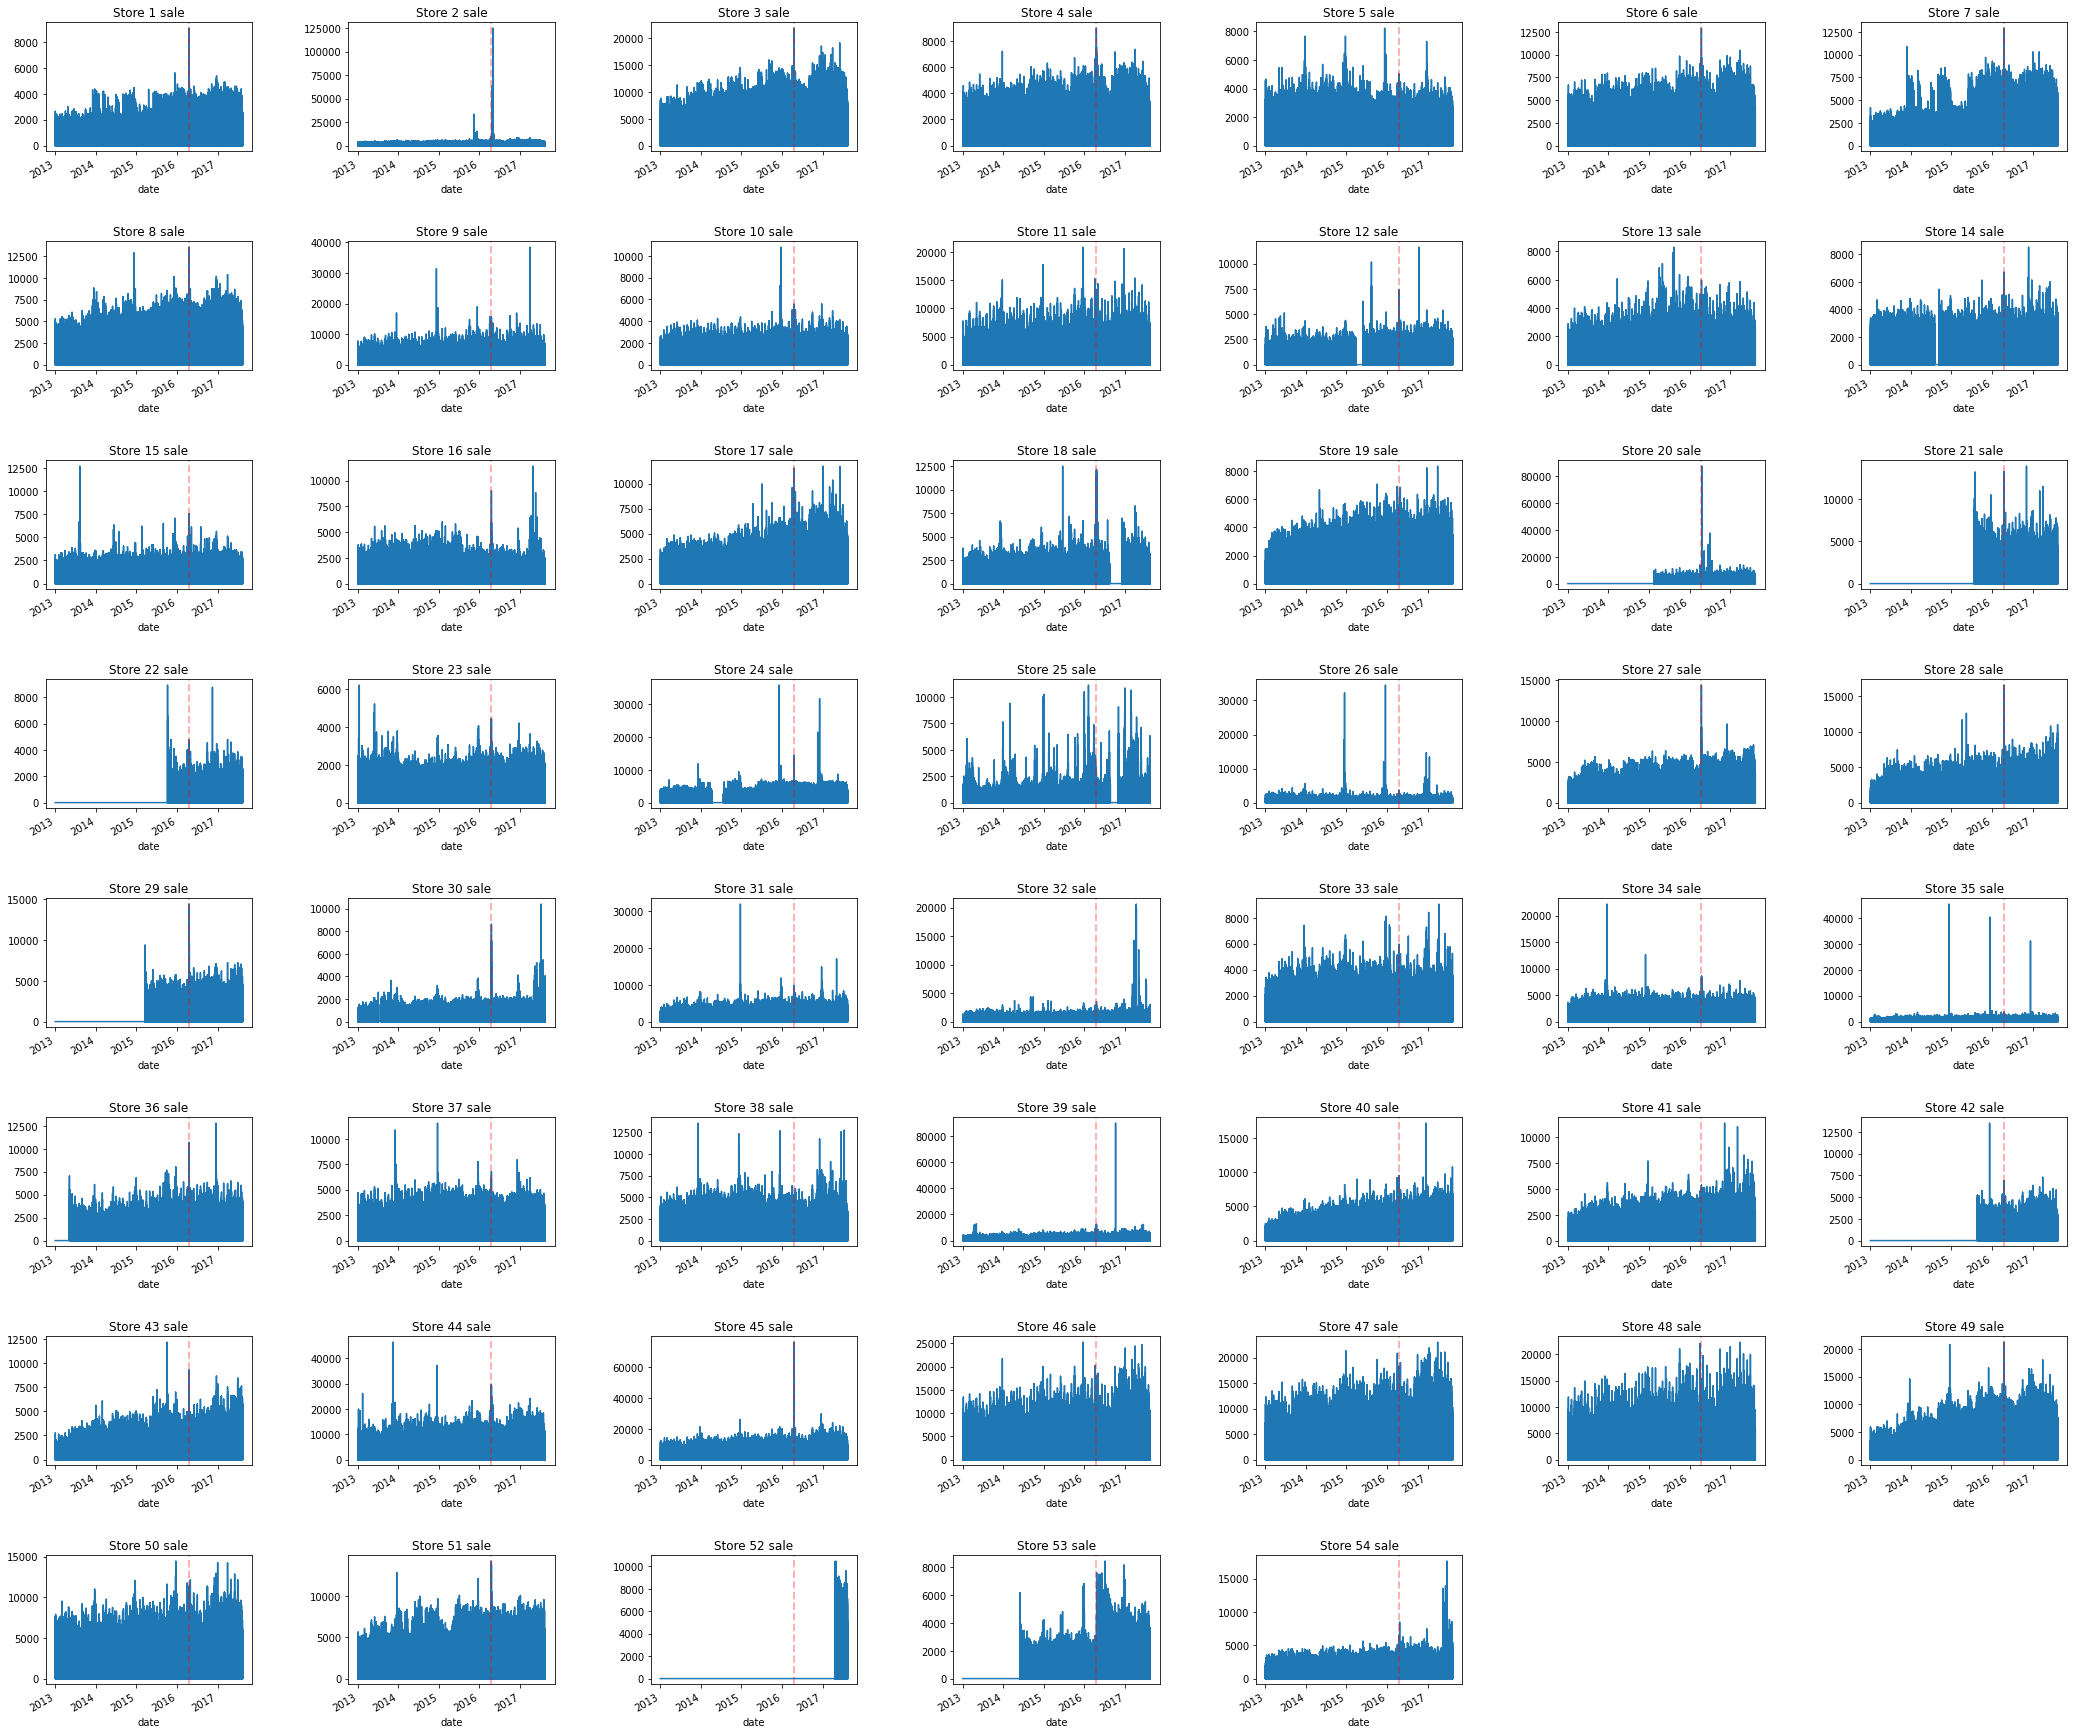

In [ ]:
fig = plt.figure(figsize=(30,30))
for i in daily_sale_dict.keys():
    plt.subplot(8,7,i)
    plt.title('Store {} sale'.format(i))
    plt.tight_layout(pad=5)
    sale = daily_sale_dict[i].sales
    sale.plot()
    plt.axvline(x=pd.Timestamp('2016-04-16'),color='r',linestyle='--',linewidth=2,alpha=0.3)

In [ ]:
by_fam_dic = {}
fam_list = process_train.family.unique()

for fam in fam_list:
    by_fam_dic[fam] = process_train[process_train['family']==fam].sales

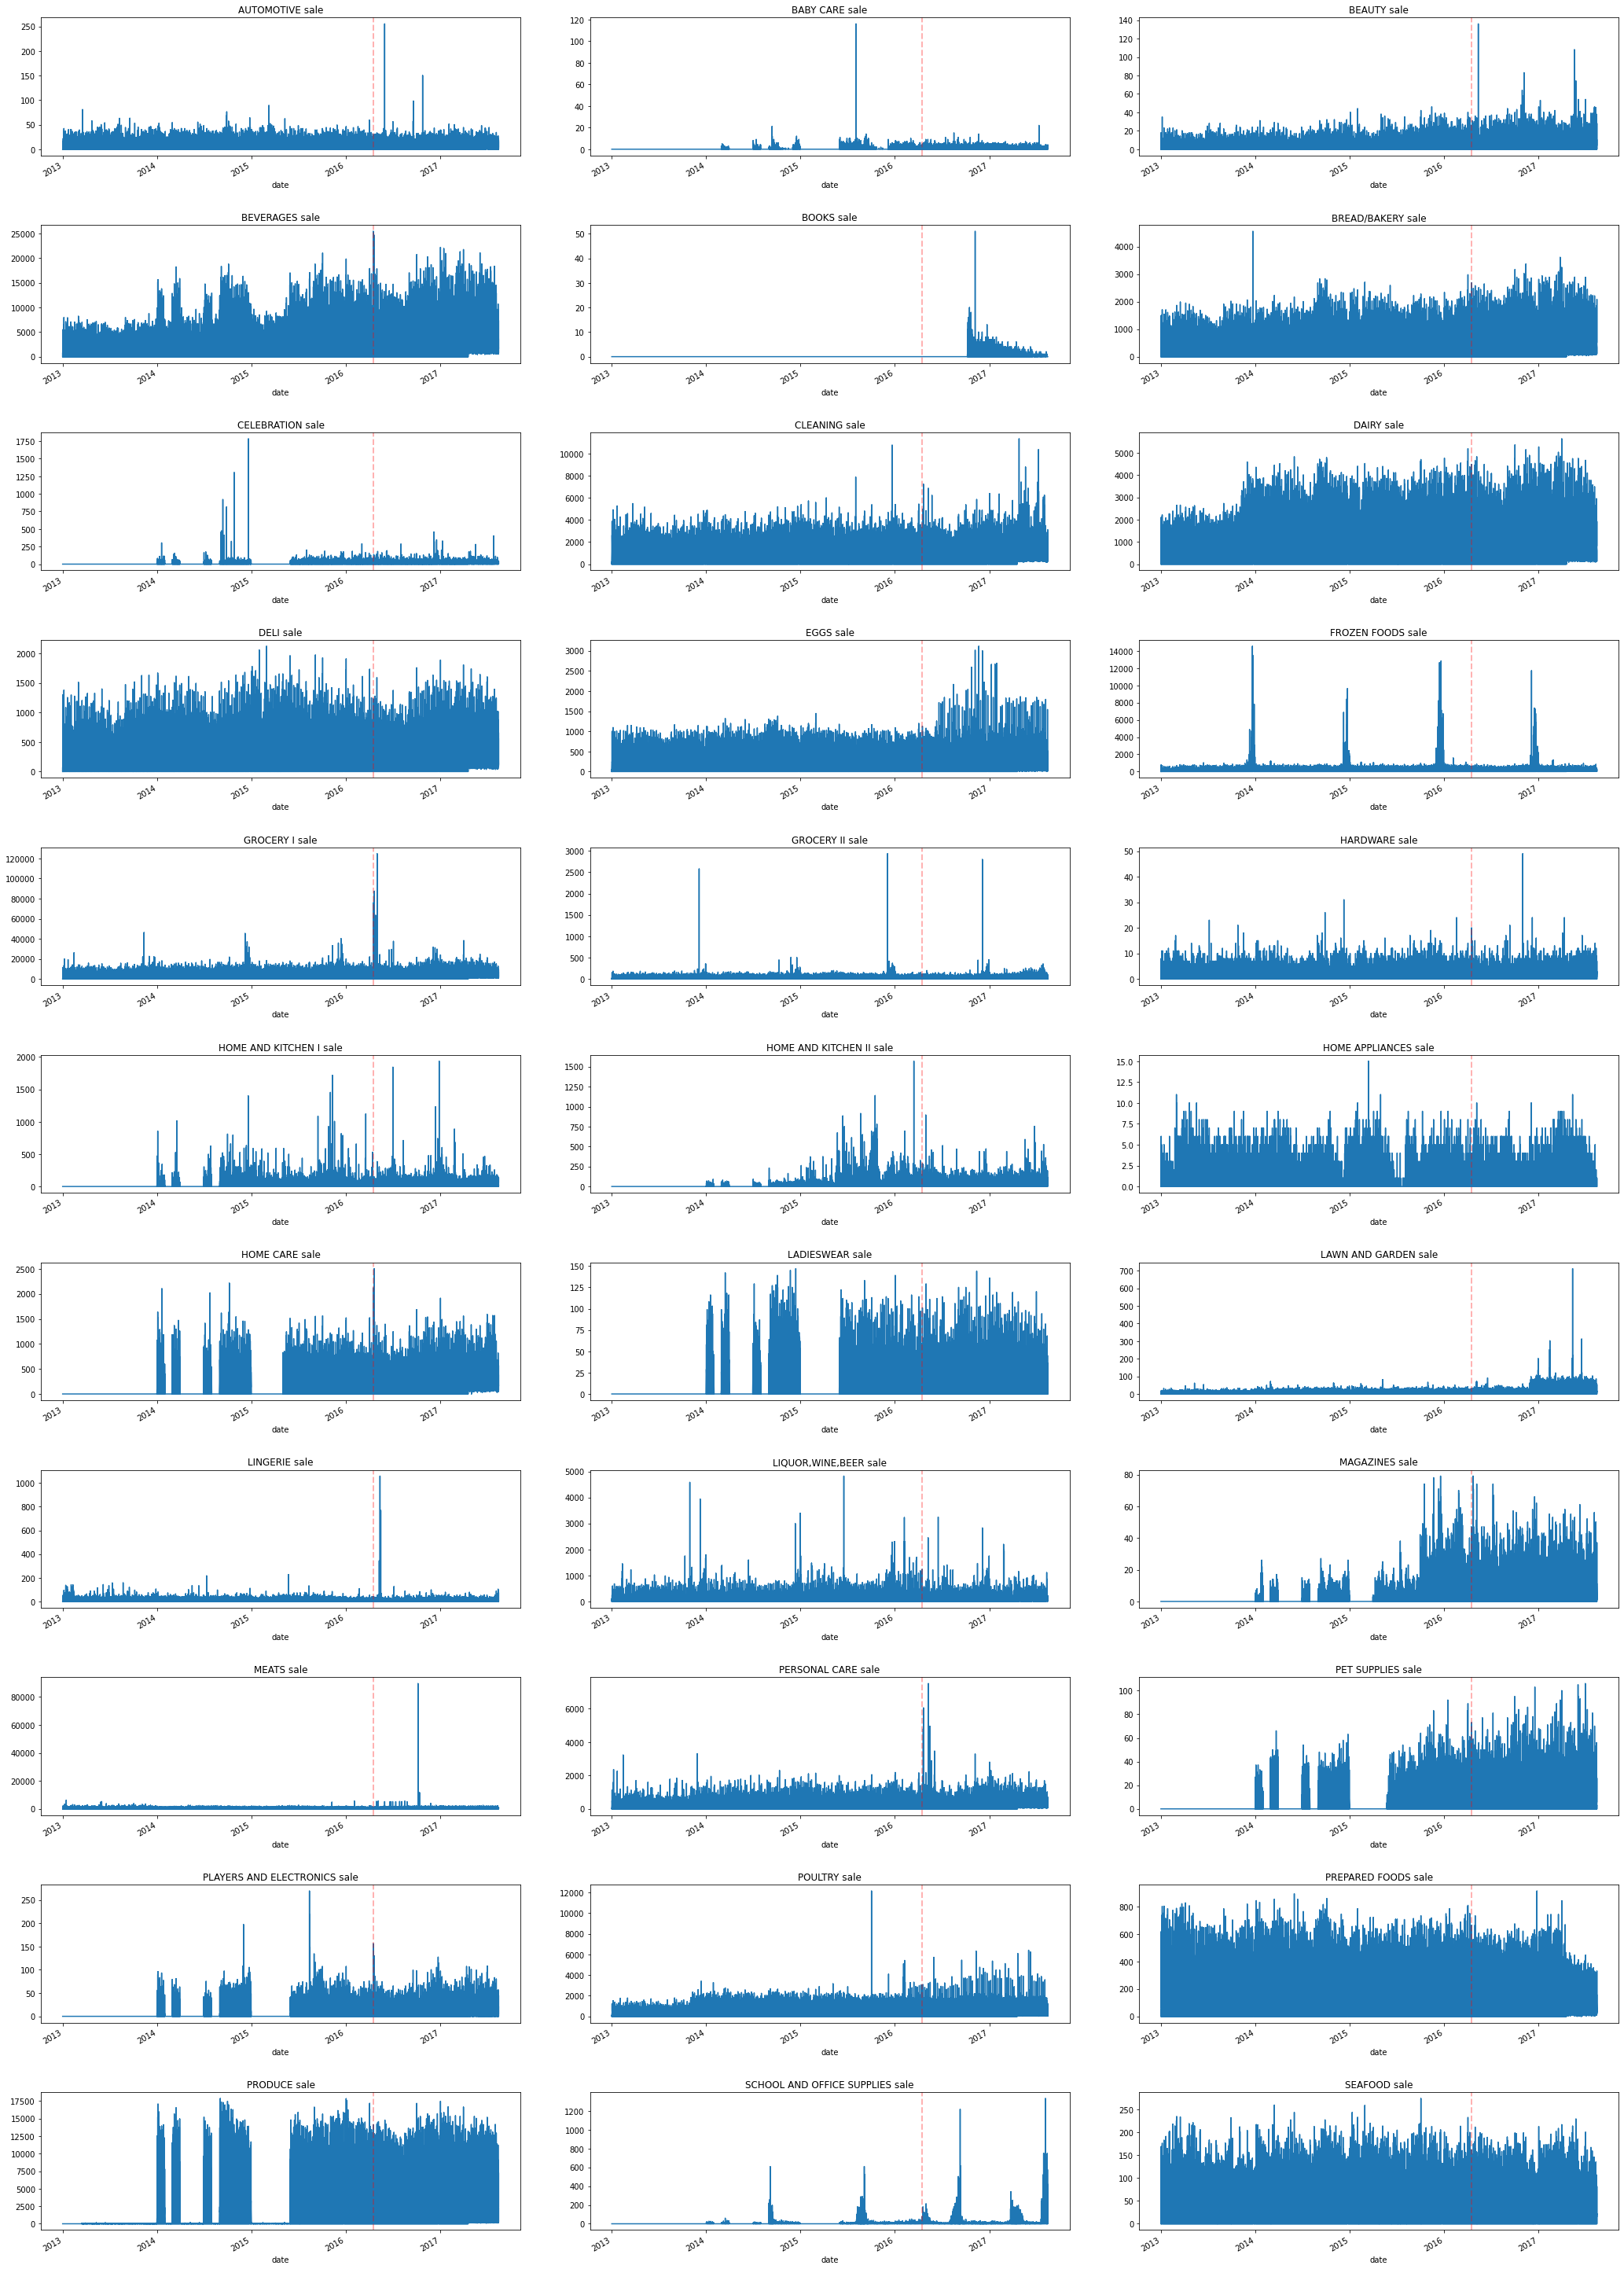

In [ ]:
fig = plt.figure(figsize=(30,50))

for i,fam in enumerate(by_fam_dic.keys()):
    plt.subplot(11,3,i+1)
    plt.title('{} sale'.format(fam))
    plt.tight_layout(pad=5)
    sale = by_fam_dic[fam]
    sale.plot()
    plt.axvline(x=pd.Timestamp('2016-04-16'),color='r',linestyle='--',linewidth=2,alpha=0.3)

In [ ]:
del by_fam_dic
del fam_list

In [ ]:
store_data.head(3)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8


In [ ]:
join_df = process_train.merge(store_data,on='store_nbr')
join_df.set_index(process_train.index)
join_df['date'] = process_train.index
join_df = join_df.set_index('date')

join_df.head()

,store_nbr,family,sales,onpromotion,city,state,type,cluster
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [ ]:
 def show_type_df(join_store_type_df):
    mean_sales_type = join_store_type_df.groupby('type').sales.mean()
    median_sales_type = join_store_type_df.groupby('type').sales.median()
    number=join_store_type_df.groupby('type').store_nbr.nunique()

    type_df = pd.DataFrame((mean_sales_type,median_sales_type,number))
    type_df = type_df.T
    type_df.columns = ['mean','median','number of store']

    return type_df


In [ ]:
show_type_df(join_df)

,mean,median,number of store
type,,,
A,705.878743,24.0,9.0
B,326.739714,7.0,8.0
C,197.263301,5.0,15.0
D,350.979407,16.0,18.0
E,269.121301,4.0,4.0


In [ ]:
def show_cluster_summary(join_store_type_df):
    mean_sales_cluster = join_store_type_df.groupby('cluster').sales.mean()
    median_sales_cluster = join_store_type_df.groupby('cluster').sales.median()
    number=join_store_type_df.groupby('cluster').store_nbr.nunique()

    cluster_df = pd.DataFrame((mean_sales_cluster,median_sales_cluster,number))
    cluster_df = cluster_df.T
    cluster_df.columns = ['mean','median','number of store']

    return cluster_df.sort_values('mean', ascending=False)

In [ ]:
show_cluster_summary(join_df)

,mean,median,number of store
cluster,,,
5,1117.245254,75.0,1.0
14,708.227718,36.0,4.0
8,647.377856,42.0,3.0
11,603.507018,5.0,3.0
17,592.231511,27.0,1.0
6,342.661732,7.0,6.0
1,326.163967,15.0,3.0
12,324.461406,10.0,1.0
13,324.364108,14.0,4.0


In [ ]:
def show_city_df(join_store_type_df):    
    mean_sales_city = join_store_type_df.groupby('city').sales.mean()
    median_sales_city = join_store_type_df.groupby('city').sales.median()
    number=join_store_type_df.groupby('city').store_nbr.nunique()

    city_df = pd.DataFrame((mean_sales_city,median_sales_city,number))
    city_df = city_df.T
    city_df.columns = ['mean','median','number of store']

    return city_df.sort_values('mean', ascending=False)

In [ ]:
show_city_df(join_df)

,mean,median,number of store
city,,,
Quito,556.577090,24.0,18.0
Cayambe,509.709179,15.0,1.0
Ambato,362.632273,21.0,2.0
Daule,345.282181,18.0,1.0
Loja,339.379530,22.0,1.0
Babahoyo,319.349181,10.0,1.0
Machala,300.392253,13.0,2.0
Esmeraldas,294.963151,7.0,1.0
Cuenca,294.924279,8.0,3.0


In [ ]:
del join_df

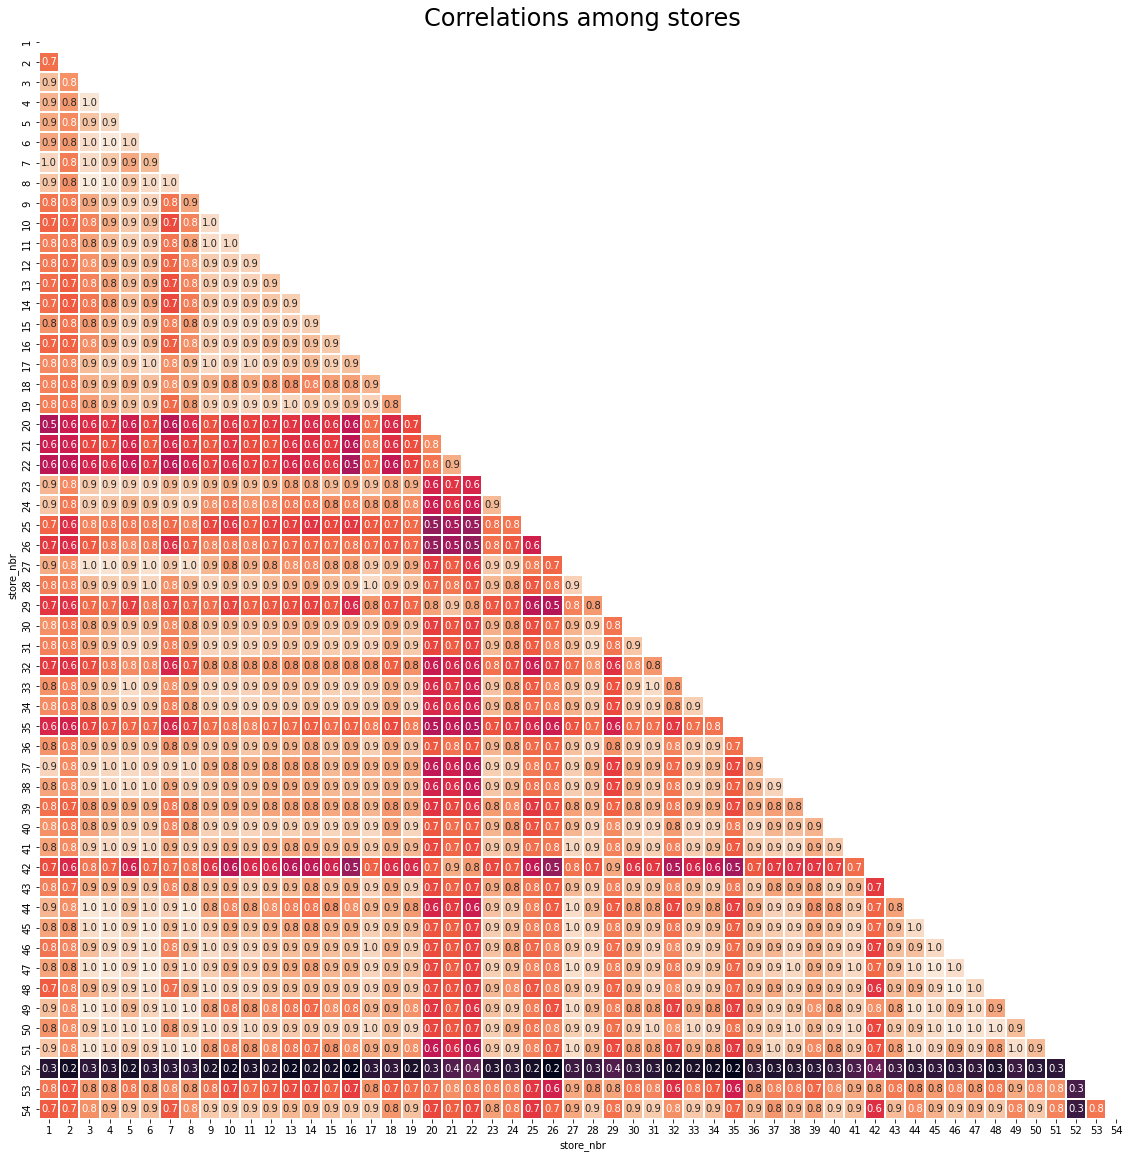

In [ ]:
import seaborn as sns

a = process_train[["store_nbr", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("store_nbr").ind.cumsum().values 
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr() 

mask = np.triu(a.corr())

plt.figure(figsize=(20, 20))
sns.heatmap(a,
         annot=True,
         fmt='.1f',
         square=True,
         mask=mask,
         linewidths=1,
         cbar=False)
plt.title("Correlations among stores",fontsize = 24)
plt.show()

In [ ]:
gc.collect()

78557

In [ ]:
store_20 = process_train.groupby(['store_nbr','date']).sales.sum().loc[20]
store_20.loc['2013-01-01':'2015-01-01']

date
2013-01-01    0.0
2013-01-02    0.0
2013-01-03    0.0
2013-01-04    0.0
2013-01-05    0.0
             ... 
2014-12-28    0.0
2014-12-29    0.0
2014-12-30    0.0
2014-12-31    0.0
2015-01-01    0.0
Name: sales, Length: 729, dtype: float64

In [ ]:
del store_20

In [ ]:
print('Spearman Rank Correlation = {}'.format(
    process_train.sales.corr(process_train.onpromotion,method='spearman')))

Spearman Rank Correlation = 0.5380218163559225


In [ ]:
from datetime import datetime as dt

def show_dow_sales():
    day_group = process_train.reset_index()[['date','sales']]
    day_group = day_group.groupby('date')
    day_group = day_group.sales.mean().to_frame()
    day_group['dow'] = day_group.index.day_of_week
    day_group = day_group.groupby('dow').sum()
    plt.bar(day_group.index,day_group['sales'])
    plt.title('Average sales on day of week')
    plt.show()

In [ ]:
def show_month_group_sale():
    month_group = process_train['sales'].to_frame()
    month_group['moy'] = month_group.index.month
    month_group = month_group.groupby('moy').sales.mean().to_frame()
    plt.bar(month_group.index,month_group['sales'])
    plt.title('Average sales on Month of Year')
    plt.show()

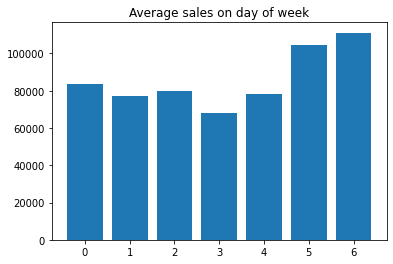

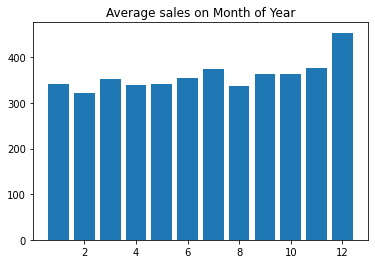

In [ ]:
show_dow_sales()
show_month_group_sale()

In [ ]:
holiday_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Projects/Store Sales by time series/holidays_events.csv",index_col='date',parse_dates=['date'])
holiday_data

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [ ]:
holiday_data.locale_name.value_counts().head()

Ecuador      174
Quito         13
Riobamba      12
Guaranda      12
Latacunga     12
Name: locale_name, dtype: int64

In [ ]:
ny_dic = {'type': 'Holiday','locale':'National','locale_name':'Ecuador','description': 'New Year Day','transferred':'False'}
ny_date = pd.to_datetime(['2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01'])

cm_dic = {'type': 'Holiday','locale':'National','locale_name':'Ecuador','description': 'Christmas Day','transferred':'False'}
cm_date = pd.to_datetime(['2012-12-25','2013-12-25','2014-12-25','2015-12-25','2016-12-25','2017-12-25','2018-12-25'])

In [ ]:
for date in ny_date:
    holiday_data.loc[date] = ['Holiday','National', 'Ecuador', 'New Year day','False']
    
for date in cm_date:
    holiday_data.loc[date] = ['Holiday','National', 'Ecuador', 'Christmas day','False']

In [ ]:
holiday_data = holiday_data.sort_index()

In [ ]:
calendar = pd.DataFrame(index = pd.date_range('2013-01-01','2017-08-31'))
calendar = calendar.join(holiday_data).fillna(0)
del holiday_data
calendar

,type,locale,locale_name,description,transferred
2013-01-01,Holiday,National,Ecuador,New Year day,False
2013-01-02,0,0,0,0,0
2013-01-03,0,0,0,0,0
2013-01-04,0,0,0,0,0
2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
...,...,...,...,...,...
2017-08-27,0,0,0,0,0
2017-08-28,0,0,0,0,0
2017-08-29,0,0,0,0,0
2017-08-30,0,0,0,0,0


In [ ]:
calendar['dow'] = calendar.index.dayofweek+1
calendar['workday'] = True
calendar.loc[calendar['dow']>5 , 'workday'] = False

calendar.head()

,type,locale,locale_name,description,transferred,dow,workday
2013-01-01,Holiday,National,Ecuador,New Year day,False,2,True
2013-01-02,0,0,0,0,0,3,True
2013-01-03,0,0,0,0,0,4,True
2013-01-04,0,0,0,0,0,5,True
2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False,6,False


In [ ]:
calendar.loc[(calendar['type']=='Holiday') & (calendar['locale'].str.contains('National')), 'workday'] = False
calendar.loc[(calendar['type']=='Additional') & (calendar['locale'].str.contains('National')), 'workday'] = False
calendar.loc[(calendar['type']=='Bridge') & (calendar['locale'].str.contains('National')), 'workday'] = False
calendar.loc[(calendar['type']=='Transfer') & (calendar['locale'].str.contains('National')), 'workday'] = False

calendar.loc[calendar['type']=='Work Day' , 'workday'] = True

In [ ]:
calendar.where(calendar['transferred'] == True).dropna()

,type,locale,locale_name,description,transferred,dow,workday
2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,3.0,False
2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,4.0,False
2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True,2.0,False
2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True,1.0,True
2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True,3.0,False
2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True,3.0,True
2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True,3.0,False
2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True,4.0,False


In [ ]:
calendar.loc[(calendar['transferred'] == True), 'workday'] = True

In [ ]:
calendar.where(calendar['description'].str.contains('futbol')).dropna()

,type,locale,locale_name,description,transferred,dow,workday
2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil,False,4.0,True
2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False,7.0,False
2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False,5.0,True
2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False,3.0,True
2014-06-28,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,6.0,False
2014-06-29,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,7.0,False
2014-06-30,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,1.0,True
2014-07-01,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,2.0,True
2014-07-04,Event,National,Ecuador,Mundial de futbol Brasil: Cuartos de Final,False,5.0,True
2014-07-05,Event,National,Ecuador,Mundial de futbol Brasil: Cuartos de Final,False,6.0,False


In [ ]:
calendar['is_football'] = 0
calendar['is_eq'] = 0

calendar.loc[(calendar['is_football'] == 0) & (calendar['description'].str.contains('futbol')), 'is_football'] = 1
calendar.loc[(calendar['is_eq'] == 0) & (calendar['description'].str.contains('Terremoto')), 'is_eq'] = 1

In [ ]:
calendar.where(calendar['is_football']==1).dropna().head()

,type,locale,locale_name,description,transferred,dow,workday,is_football,is_eq
2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil,False,4.0,True,1.0,0.0
2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False,7.0,False,1.0,0.0
2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False,5.0,True,1.0,0.0
2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False,3.0,True,1.0,0.0
2014-06-28,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,6.0,False,1.0,0.0


In [ ]:
calendar.where(calendar['is_eq']==1).dropna().head()

,type,locale,locale_name,description,transferred,dow,workday,is_football,is_eq
2016-04-16,Event,National,Ecuador,Terremoto Manabi,False,6.0,False,0.0,1.0
2016-04-17,Event,National,Ecuador,Terremoto Manabi+1,False,7.0,False,0.0,1.0
2016-04-18,Event,National,Ecuador,Terremoto Manabi+2,False,1.0,True,0.0,1.0
2016-04-19,Event,National,Ecuador,Terremoto Manabi+3,False,2.0,True,0.0,1.0
2016-04-20,Event,National,Ecuador,Terremoto Manabi+4,False,3.0,True,0.0,1.0


In [ ]:
calendar.loc[calendar['is_football']==1,'description'] = 'football'
calendar.loc[calendar['is_eq']==1,'description'] = 'earthquake'

In [ ]:
sales = process_train.groupby('date').sales.sum()
event = calendar[calendar['type']=='Event']

event_merge = event.merge(sales,how='left',left_index=True,right_index=True)
event_merge

del sales
del event

In [ ]:
print('mean of daily sale across country: {}'.format(process_train.groupby('date').sales.sum().mean()))
print('--------------------')

print(('mean of sale across country in event day: {}'.format(event_merge.groupby('description').sales.mean())))

mean of daily sale across country: 637556.3849186868
--------------------
mean of sale across country in event day: description
Black Friday       647508.781658
Cyber Monday       777344.484674
Dia de la Madre    621092.051781
earthquake         881919.056300
football           554139.887353
Name: sales, dtype: float64


In [ ]:
calendar.head()

,type,locale,locale_name,description,transferred,dow,workday,is_football,is_eq
2013-01-01,Holiday,National,Ecuador,New Year day,False,2,False,0,0
2013-01-02,0,0,0,0,0,3,True,0,0
2013-01-03,0,0,0,0,0,4,True,0,0
2013-01-04,0,0,0,0,0,5,True,0,0
2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False,6,True,0,0


In [ ]:
calendar['workday'] = calendar['workday'].map({False:0,True:1})
calendar['transferred'] = calendar['transferred'].map({'False':0,False:0,True:1})

In [ ]:
calendar['is_ny'] = 0
calendar['is_christmas'] = 0
calendar['is_shopping'] = 0

calendar.loc[calendar['description'] == 'New Year day', 'is_ny'] = 1
calendar.loc[calendar['description'] == 'Christmas day', 'is_christmas'] = 1
calendar.loc[calendar['description'] == 'Black Friday', 'is_shopping'] = 1
calendar.loc[calendar['description'] == 'Cyber Monday' , 'is_shopping'] = 1

In [ ]:
calendar.loc['2014-12-25'].to_frame().T

,type,locale,locale_name,description,transferred,dow,workday,is_football,is_eq,is_ny,is_christmas,is_shopping
2014-12-25,Holiday,National,Ecuador,Christmas day,0,4,0,0,0,0,1,0


In [ ]:
calendar.head()

,type,locale,locale_name,description,transferred,dow,workday,is_football,is_eq,is_ny,is_christmas,is_shopping
2013-01-01,Holiday,National,Ecuador,New Year day,0,2,0,0,0,1,0,0
2013-01-02,0,0,0,0,0,3,1,0,0,0,0,0
2013-01-03,0,0,0,0,0,4,1,0,0,0,0,0
2013-01-04,0,0,0,0,0,5,1,0,0,0,0,0
2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,0,6,1,0,0,0,0,0


In [ ]:
locale_dummy = pd.get_dummies(calendar['locale_name'],prefix='holiday_')
calendar = locale_dummy.join(calendar,how='left')
calendar = calendar.drop('locale_name',axis=1)

del locale_dummy

In [ ]:
calendar_checkpoint = calendar

In [ ]:
calendar_checkpoint = calendar_checkpoint.drop('description',axis = 1)
calendar_checkpoint = calendar_checkpoint[~calendar_checkpoint.index.duplicated(keep='first')] 
calendar_checkpoint = calendar_checkpoint.iloc[:,1:-1]

In [ ]:
calendar_checkpoint

,holiday__Ambato,holiday__Cayambe,holiday__Cotopaxi,holiday__Cuenca,holiday__Ecuador,holiday__El Carmen,holiday__Esmeraldas,holiday__Guaranda,holiday__Guayaquil,holiday__Ibarra,...,holiday__Santo Domingo de los Tsachilas,type,locale,transferred,dow,workday,is_football,is_eq,is_ny,is_christmas
2013-01-01,0,0,0,0,1,0,0,0,0,0,...,0,Holiday,National,0,2,0,0,0,1,0
2013-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,1,0,0,0,0
2013-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,1,0,0,0,0
2013-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,1,0,0,0,0
2013-01-05,0,0,0,0,1,0,0,0,0,0,...,0,Work Day,National,0,6,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7,0,0,0,0,0
2017-08-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2017-08-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,1,0,0,0,0
2017-08-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,1,0,0,0,0


In [ ]:
del calendar
gc.collect()

5852

In [ ]:
oil_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Projects/Store Sales by time series/oil.csv")

In [ ]:
oil_data.head(4)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12


In [ ]:
pd.date_range(start = '2013-01-01', end = '2017-08-15' ).difference(oil_data.index)

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [ ]:
oil_data['date'] = pd.to_datetime(oil_data['date'])
oil_data = oil_data.set_index('date')

In [ ]:
oil_data = oil_data.resample('1D').sum()

In [ ]:
oil_data.reset_index()

,date,dcoilwtico
0,2013-01-01,0.00
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,0.00
...,...,...
1699,2017-08-27,0.00
1700,2017-08-28,46.40
1701,2017-08-29,46.46
1702,2017-08-30,45.96


In [ ]:
pd.date_range(start = '2013-01-01', end = '2017-08-15' ).difference(oil_data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [ ]:
oil_data['dcoilwtico'] = np.where(oil_data['dcoilwtico']==0, np.nan, oil_data['dcoilwtico'])
oil_data['interpolated_price'] = oil_data.dcoilwtico.interpolate()

In [ ]:
oil_data = oil_data.drop('dcoilwtico',axis=1)

In [ ]:
oil_data.head()

,interpolated_price
date,
2013-01-01,NaN
2013-01-02,93.140000
2013-01-03,92.970000
2013-01-04,93.120000
2013-01-05,93.146667


In [ ]:
oil_data['price_chg'] = oil_data.interpolated_price - oil_data.interpolated_price.shift(1)
oil_data['pct_chg'] = oil_data['price_chg']/oil_data.interpolated_price.shift(-1)

In [ ]:
oil_data.head()

,interpolated_price,price_chg,pct_chg
date,,,
2013-01-01,NaN,NaN,NaN
2013-01-02,93.140000,NaN,NaN
2013-01-03,92.970000,-0.170000,-0.001826
2013-01-04,93.120000,0.150000,0.001610
2013-01-05,93.146667,0.026667,0.000286


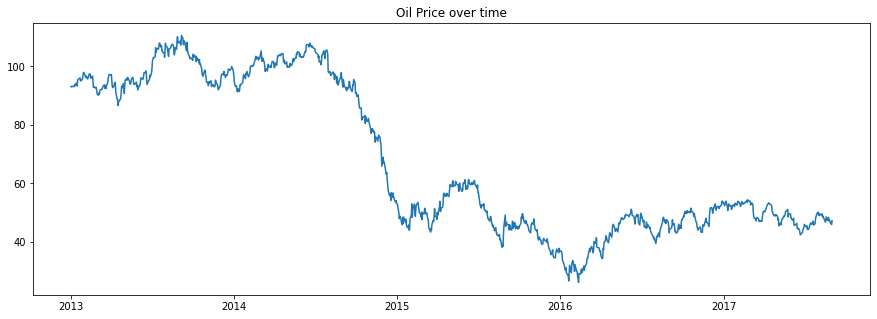

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(oil_data['interpolated_price'])
plt.title('Oil Price over time')

plt.show()

In [ ]:
daily_total_sales = total_sales.copy()

In [ ]:
daily_total_sales.head()

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
Name: sales, dtype: float64

In [ ]:
daily_total_sales = daily_total_sales.resample('1D').sum()
daily_total_sales

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Freq: D, Name: sales, Length: 1688, dtype: float64

In [ ]:
oil_data.interpolated_price.loc['2013-01-01':'2017-08-15']

date
2013-01-01          NaN
2013-01-02    93.140000
2013-01-03    92.970000
2013-01-04    93.120000
2013-01-05    93.146667
                ...    
2017-08-11    48.810000
2017-08-12    48.403333
2017-08-13    47.996667
2017-08-14    47.590000
2017-08-15    47.570000
Freq: D, Name: interpolated_price, Length: 1688, dtype: float64

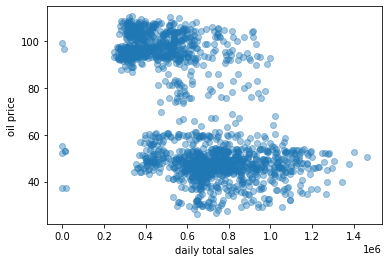

In [ ]:
plt.scatter(daily_total_sales,oil_data.interpolated_price.loc['2013-01-01':'2017-08-15'],alpha=0.4)
plt.ylabel('oil price')
plt.xlabel('daily total sales')
plt.show()

In [ ]:
daily_total_sales = pd.DataFrame(daily_total_sales)
daily_total_sales['sales_chg'] = daily_total_sales['sales']-daily_total_sales['sales'].shift(1)
daily_total_sales['sales_pct_chg'] = daily_total_sales['sales_chg']/daily_total_sales['sales'].shift(-1)

daily_total_sales.head()

,sales,sales_chg,sales_pct_chg
date,,,
2013-01-01,2511.618999,NaN,NaN
2013-01-02,496092.417944,493580.798945,1.365515
2013-01-03,361461.231124,-134631.186820,-0.379821
2013-01-04,354459.677093,-7001.554031,-0.014668
2013-01-05,477350.121229,122890.444136,0.236466


In [ ]:
print('Spearman Rank Correlation = {}'.format(
    process_train.sales.corr(process_train.onpromotion,method='spearman')))

Spearman Rank Correlation = 0.5380218163559225


In [ ]:
print('Pearson Correlation between oil price change and total sales change = {}'.format(
oil_data.price_chg.corr(daily_total_sales.sales_chg,method='pearson')))
print('Spearman Rank Correlation between oil price change and total sales change = {}'.format(
oil_data.price_chg.corr(daily_total_sales.sales_chg,method='spearman')))

print('----------------------------------------------------------------------------')

print('Pearson Correlation between % oil price change and % total sales change = {}'.format(
oil_data.pct_chg.corr(daily_total_sales.sales_pct_chg,method='pearson')))
print('Spearman Rank Correlation between oil price change and total sales change = {}'.format(
oil_data.pct_chg.corr(daily_total_sales.sales_pct_chg,method='spearman')))

Pearson Correlation between oil price change and total sales change = 0.0005043962495408222
Spearman Rank Correlation between oil price change and total sales change = -0.012220920016204567
----------------------------------------------------------------------------
Pearson Correlation between % oil price change and % total sales change = nan
Spearman Rank Correlation between oil price change and total sales change = -0.009634310217587974


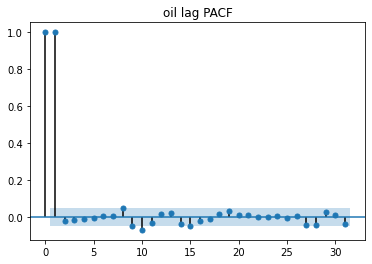

In [ ]:
import  statsmodels.graphics.tsaplots

ax = statsmodels.graphics.tsaplots.plot_pacf(oil_data.interpolated_price.dropna(), 
                                                 lags=31,
                                                 title = 'oil lag PACF')

In [ ]:
oil_lag = [10,15,26,27]
for lag in oil_lag:
    oil_data['price_lag_{}'.format(lag)] = oil_data.interpolated_price.shift(lag)

In [ ]:
oil_for_lag_coor = oil_data.dropna()
oil_for_lag_coor.head()

,interpolated_price,price_chg,pct_chg,price_lag_10,price_lag_15,price_lag_26,price_lag_27
date,,,,,,,
2013-01-29,97.620000,1.670000,0.017044,95.73,94.27,92.970000,93.140000
2013-01-30,97.980000,0.360000,0.003687,95.85,93.26,93.120000,92.970000
2013-01-31,97.650000,-0.330000,-0.003386,95.97,94.28,93.146667,93.120000
2013-02-01,97.460000,-0.190000,-0.001958,96.09,95.49,93.173333,93.146667
2013-02-02,97.043333,-0.416667,-0.004312,95.06,95.61,93.200000,93.173333


In [ ]:
oil_for_lag_coor = oil_for_lag_coor.merge(daily_total_sales,how='inner',left_index=True,right_index=True)

In [ ]:
oil_for_lag_coor = oil_for_lag_coor[['price_lag_10','price_lag_15','price_lag_26','price_lag_27','sales']]
oil_for_lag_coor.head()

,price_lag_10,price_lag_15,price_lag_26,price_lag_27,sales
date,,,,,
2013-01-29,95.73,94.27,92.970000,93.140000,264488.818076
2013-01-30,95.85,93.26,93.120000,92.970000,281061.127052
2013-01-31,95.97,94.28,93.146667,93.120000,271254.217996
2013-02-01,96.09,95.49,93.173333,93.146667,369402.055266
2013-02-02,95.06,95.61,93.200000,93.173333,518887.462705


No handles with labels found to put in legend.


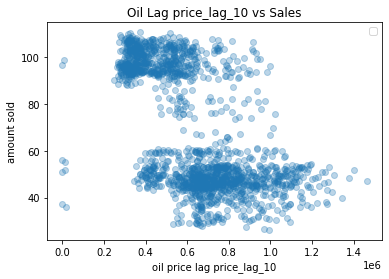

No handles with labels found to put in legend.


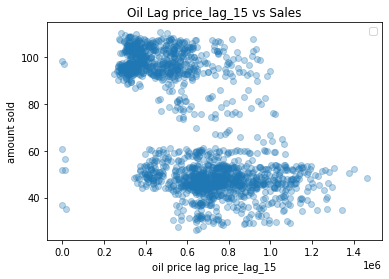

No handles with labels found to put in legend.


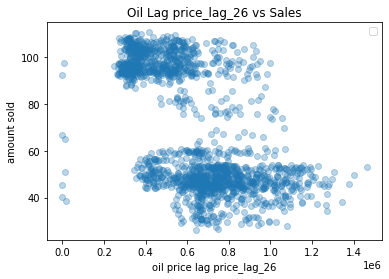

No handles with labels found to put in legend.


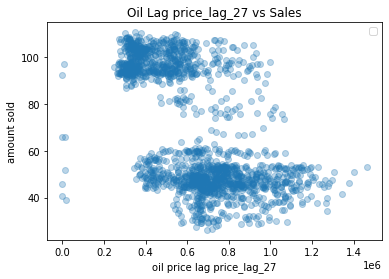

In [ ]:
fig, ax = plt.subplots()
lag_col =  ['price_lag_10','price_lag_15','price_lag_26','price_lag_27']

for lag in lag_col:
    plt.scatter(oil_for_lag_coor['sales'],oil_for_lag_coor[lag],alpha=0.30)
    plt.title('Oil Lag {} vs Sales'.format(lag))
    plt.xlabel('oil price lag {}'.format(lag))
    plt.ylabel('amount sold')
    plt.legend()
    plt.show()

In [ ]:
del [oil_lag,oil_data,oil_for_lag_coor,lag_col]

gc.collect()

93634

In [ ]:
transactions = transaction_data.copy()
transactions = transactions.set_index('date')

del transaction_data

In [ ]:
transactions.index = pd.to_datetime(transactions.index)

In [ ]:
transactions.head()

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922


In [ ]:
def transaction_sales_dic(transaction_df,sale_dic):
    transaction_dic = {}
    sale_dict = sale_dic.copy()

    for i in transaction_df['store_nbr'].unique():
        store_transacion = transaction_df.loc[transaction_df['store_nbr'] == i]
        transaction_dic[i] = store_transacion['transactions']
        
    for i in sale_dict.keys():
        sale_dict[i] = sale_dict[i].groupby(['date','store_nbr']).sales.sum()
        sale_dict[i] = sale_dict[i].reset_index()
        sale_dict[i] = sale_dict[i].drop('store_nbr', axis=1)
        sale_dict[i] = sale_dict[i].groupby('date').sales.sum()
            
    return transaction_dic, sale_dict
        
def  series_merge_inner_index(dic1, dic2):
    merged_dic = {}
    for key in dic1.keys():
        merged_dic[key] = dic1[key].to_frame().merge(dic2[key].to_frame(), how='inner',
                                                    left_index=True, right_index=True)
    return merged_dic

In [ ]:
transaction_dic, sale_dic = transaction_sales_dic(transactions,daily_sale_dict)
merged_sales_transaction = series_merge_inner_index(transaction_dic, sale_dic)
merged_sales_transaction[1]

,transactions,sales
date,,
2013-01-02,2111,7417.148000
2013-01-03,1833,5873.244001
2013-01-04,1863,5919.879001
2013-01-05,1509,6318.785010
2013-01-06,520,2199.087000
...,...,...
2017-08-11,570,5403.742021
2017-08-12,1004,7543.623000
2017-08-13,416,3902.782000


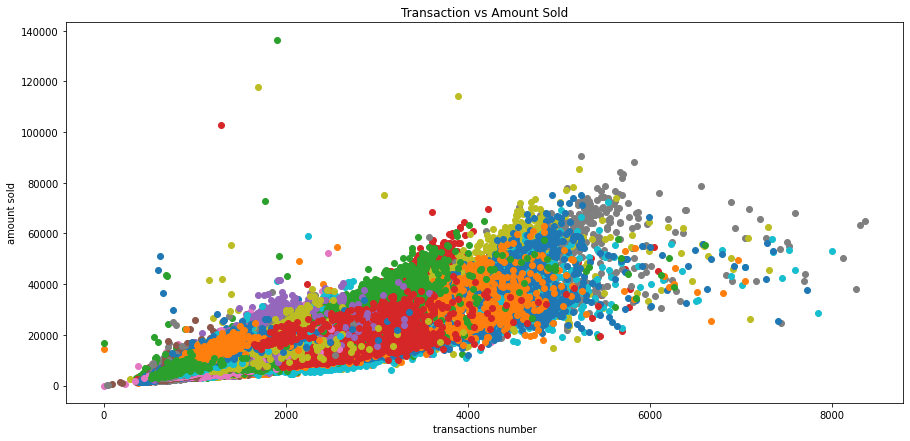

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
for key in merged_sales_transaction.keys():
    plt.scatter(merged_sales_transaction[key].transactions,
                merged_sales_transaction[key].sales)

plt.title('Transaction vs Amount Sold')
plt.xlabel('transactions number')
plt.ylabel('amount sold')
plt.show()

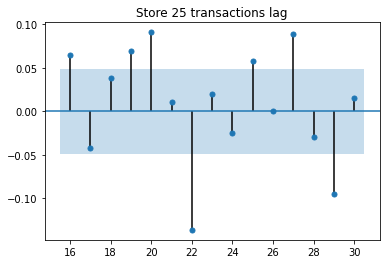

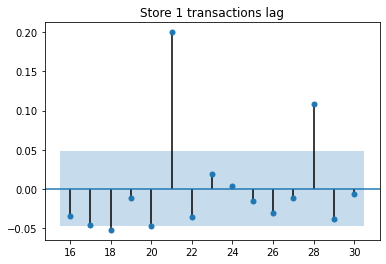

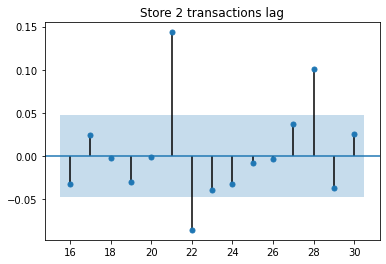

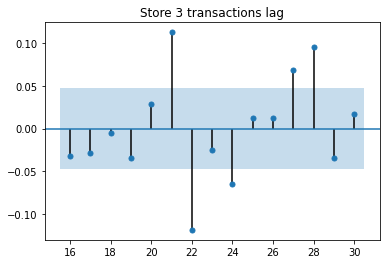

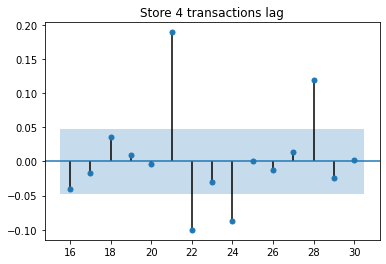

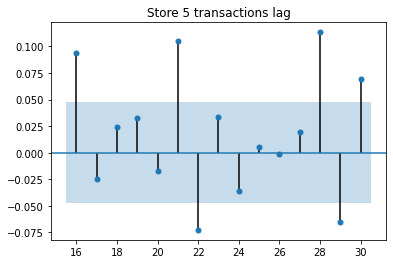

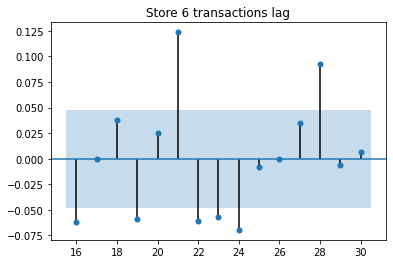

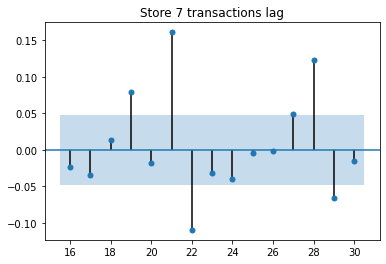

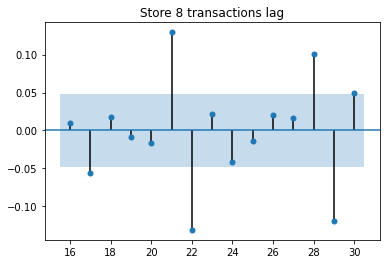

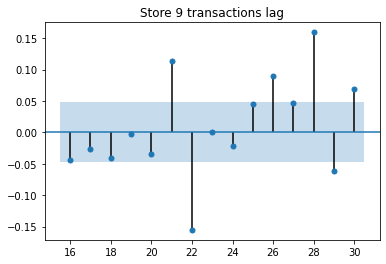

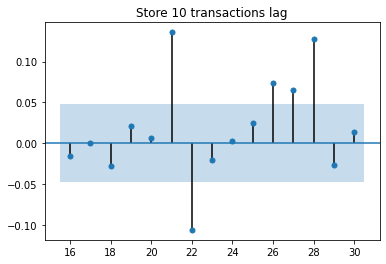

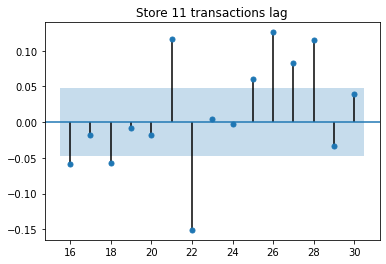

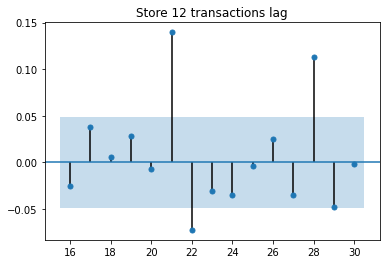

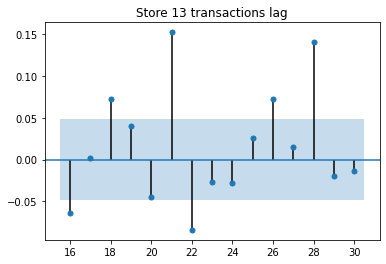

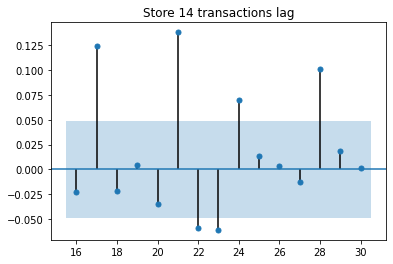

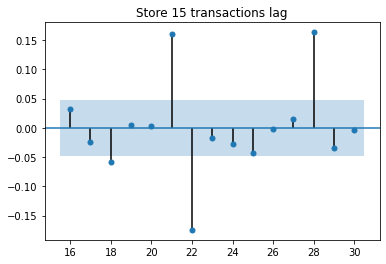

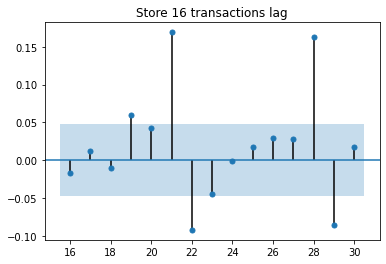

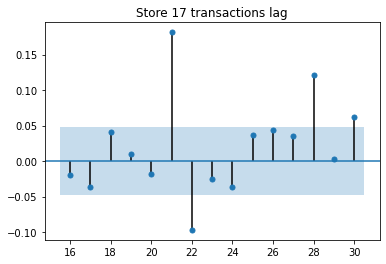

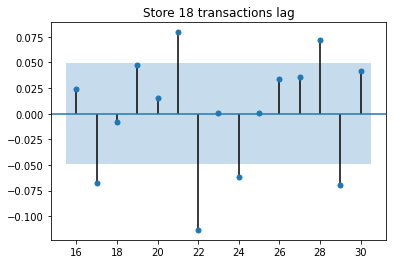

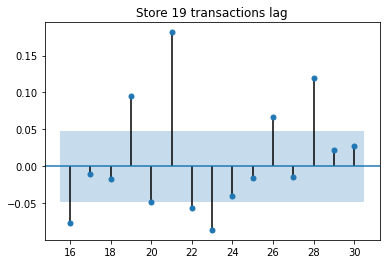

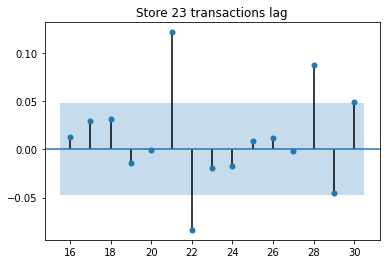

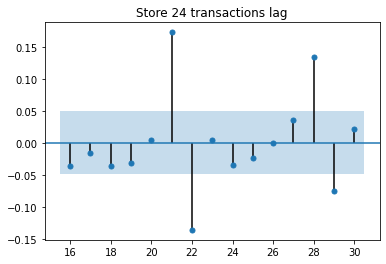

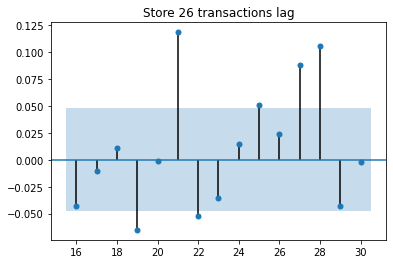

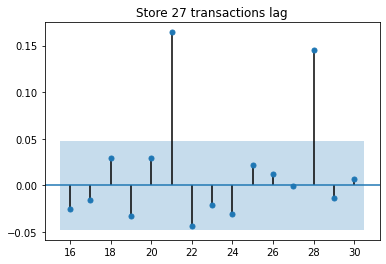

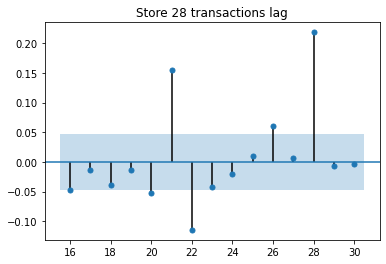

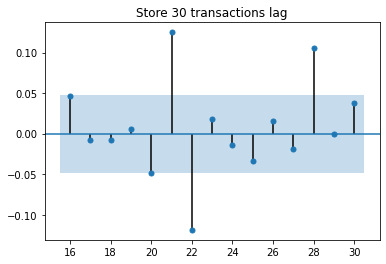

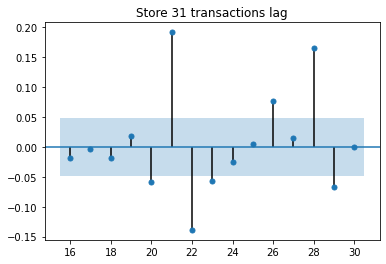

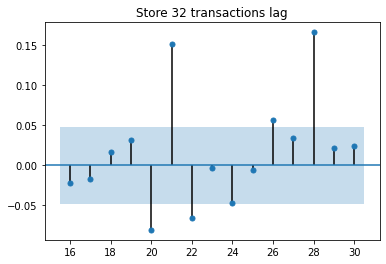

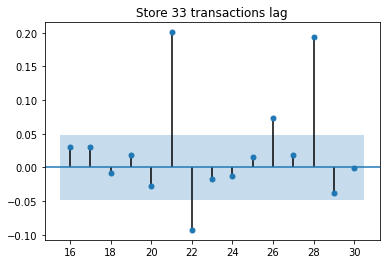

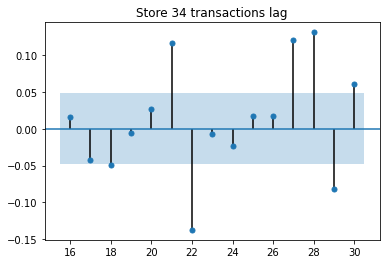

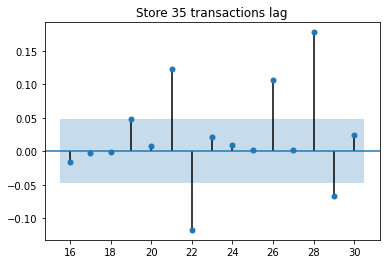

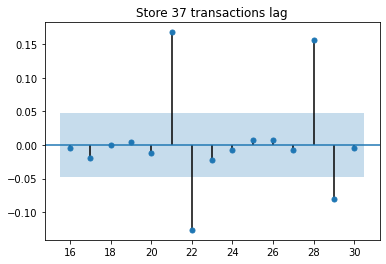

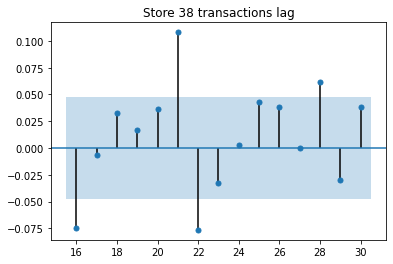

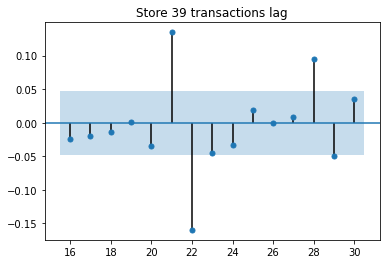

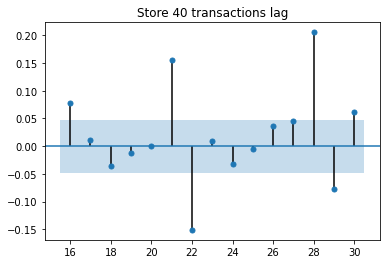

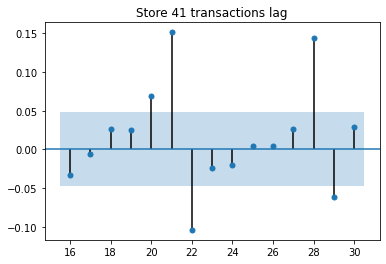

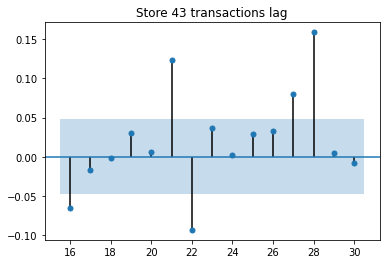

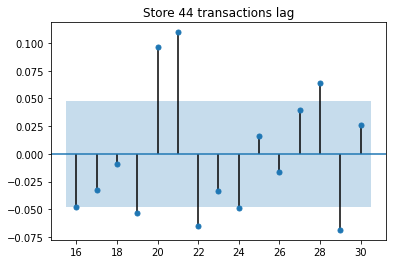

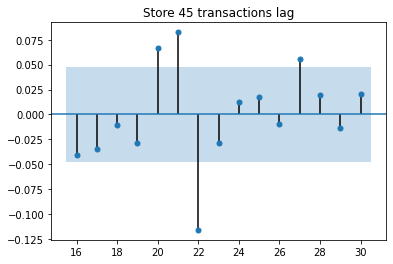

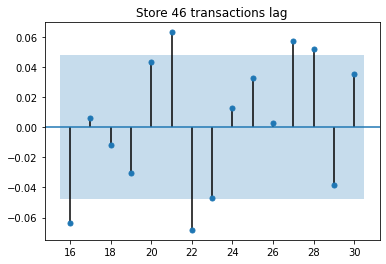

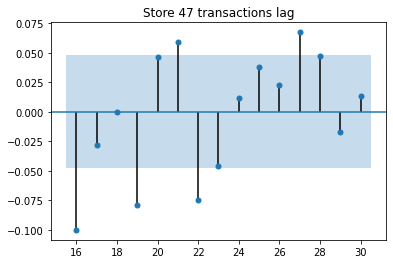

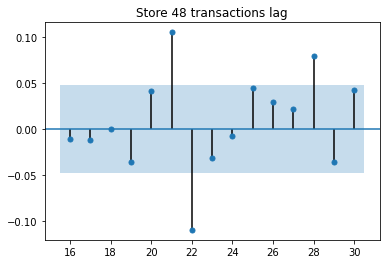

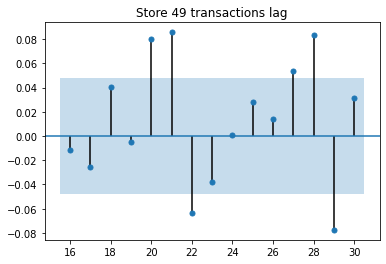

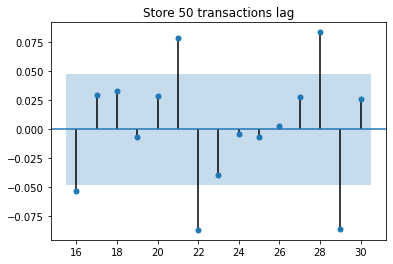

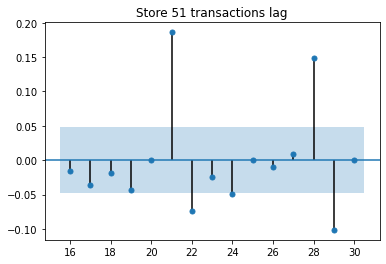

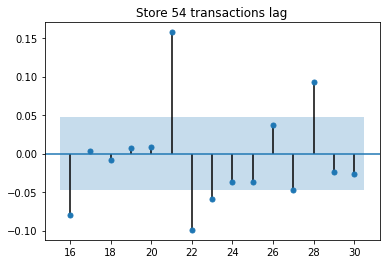

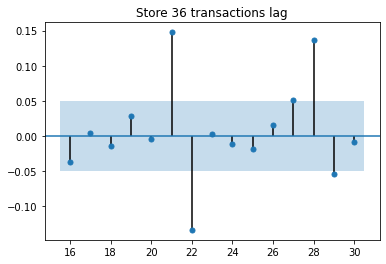

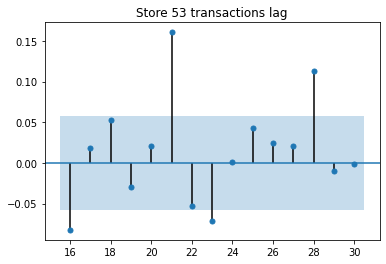

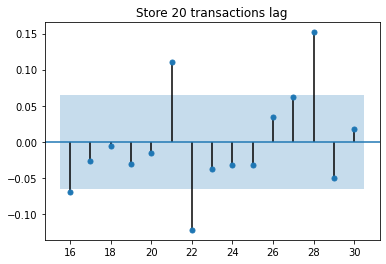

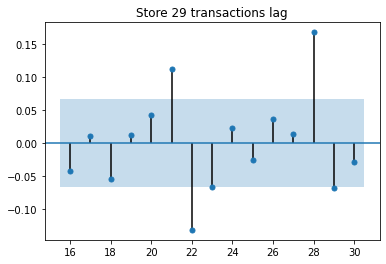

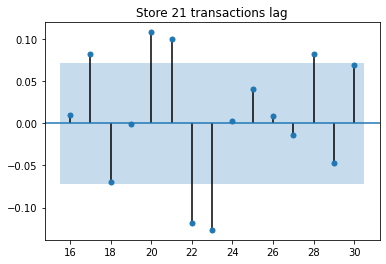

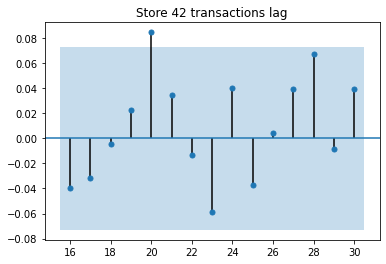

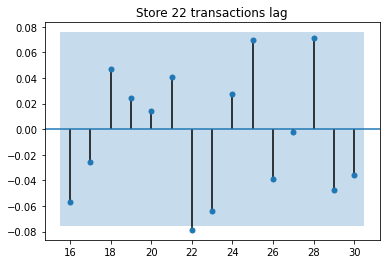

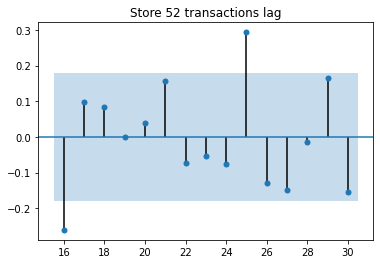

In [ ]:
import  statsmodels.graphics.tsaplots

for store_nbr in merged_sales_transaction.keys():
    ax = statsmodels.graphics.tsaplots.plot_pacf(merged_sales_transaction[store_nbr].transactions, 
                                                 lags=range(16,31),
                                                 title = 'Store {} transactions lag'.format(store_nbr))

In [ ]:
import  statsmodels.graphics.tsaplots

daily_store_sale_dict = {}
for i in daily_sale_dict.keys():
    daily_store_sale_dict[i] = daily_sale_dict[i].groupby(['date','store_nbr']).sales.sum().to_frame()

In [ ]:
del daily_sale_dict

In [ ]:
daily_store_sale_dict[1].head()

,,sales
date,store_nbr,
2013-01-01,1,0.000000
2013-01-02,1,7417.148000
2013-01-03,1,5873.244001
2013-01-04,1,5919.879001
2013-01-05,1,6318.785010


In [ ]:
for i in daily_store_sale_dict.keys():
    daily_store_sale_dict[i] = daily_store_sale_dict[i].droplevel(1) 

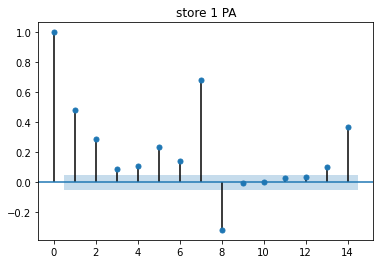

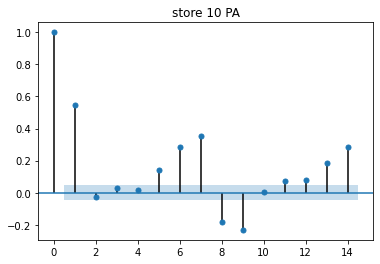

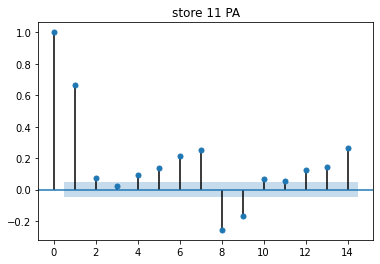

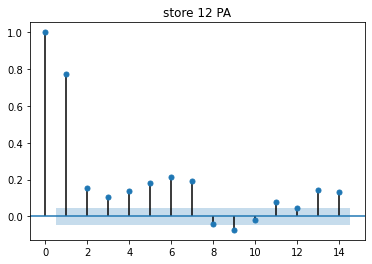

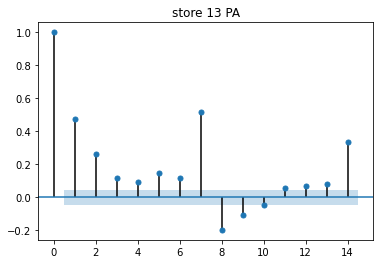

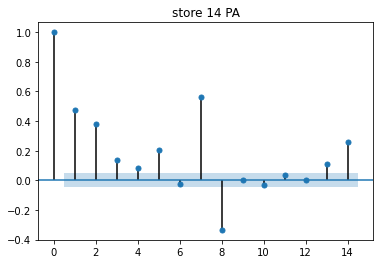

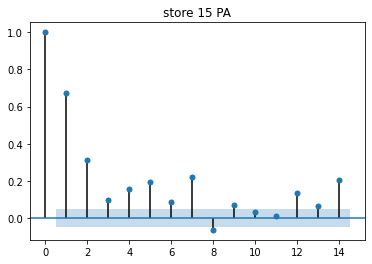

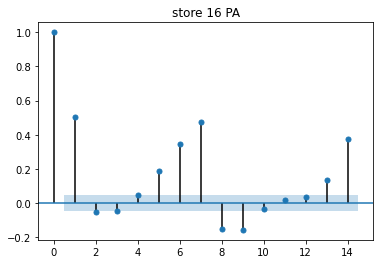

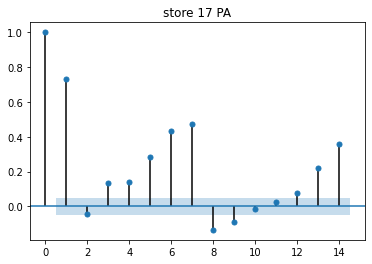

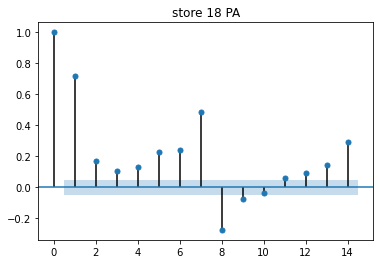

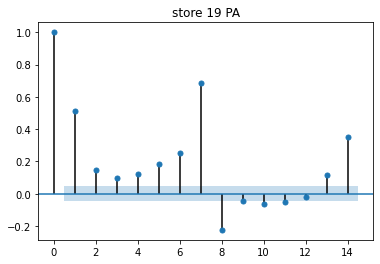

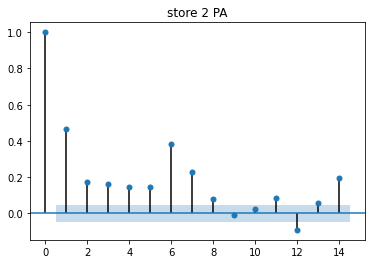

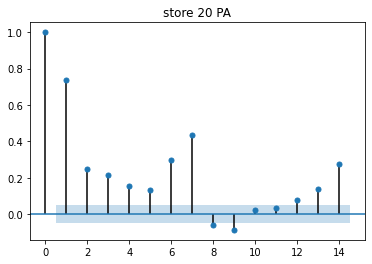

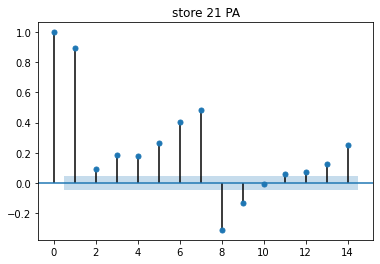

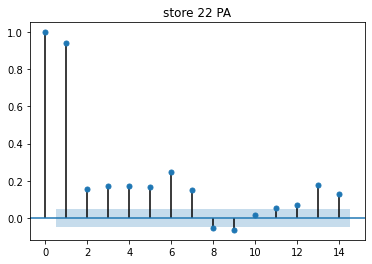

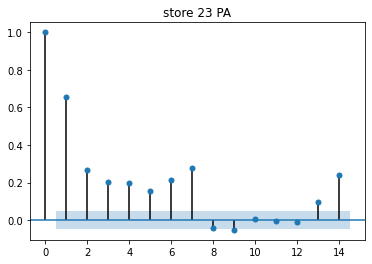

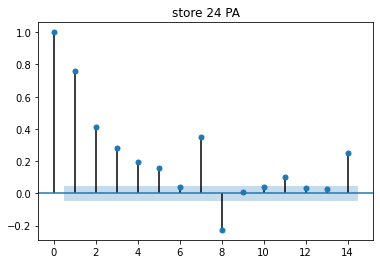

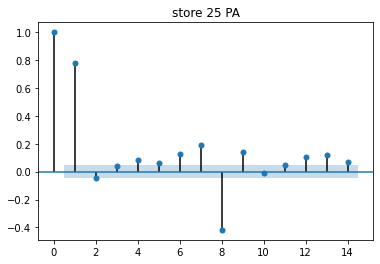

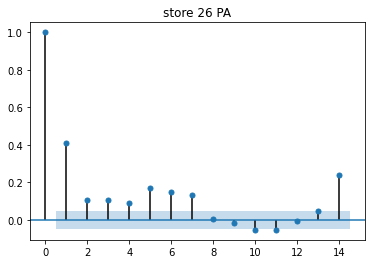

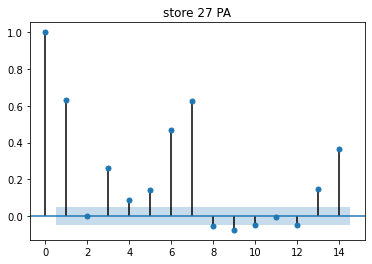

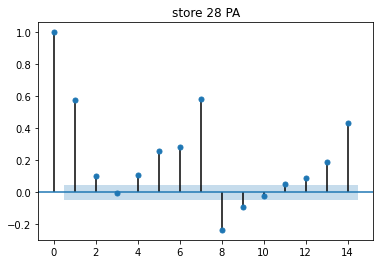

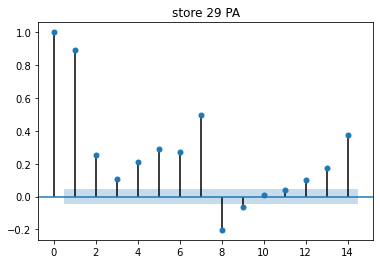

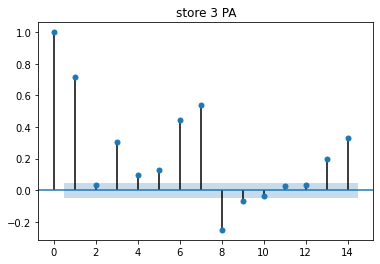

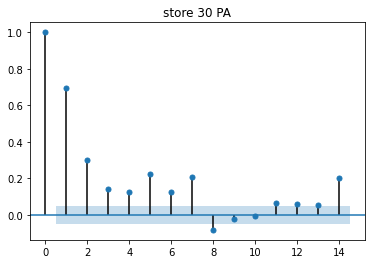

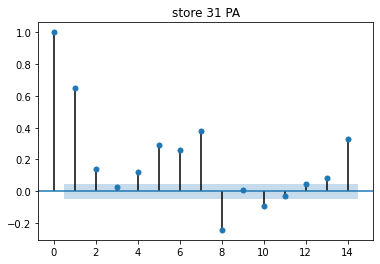

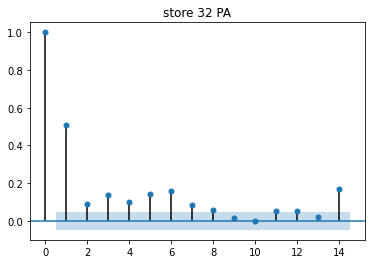

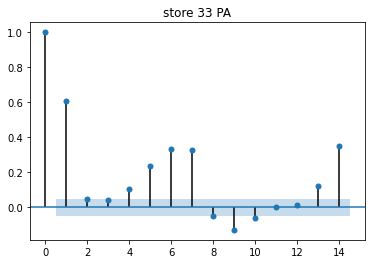

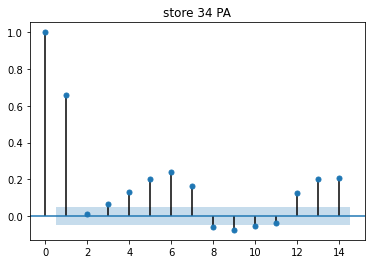

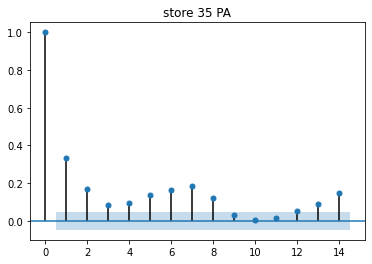

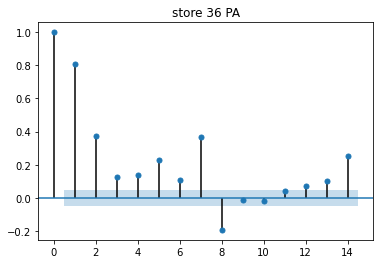

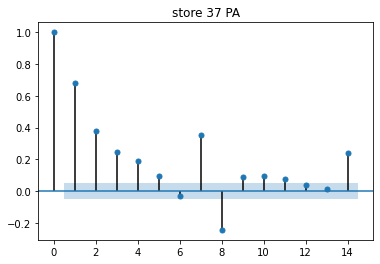

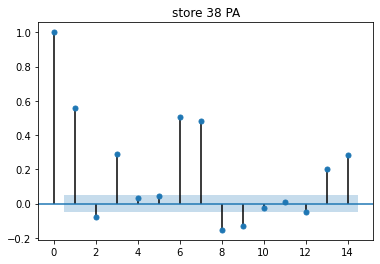

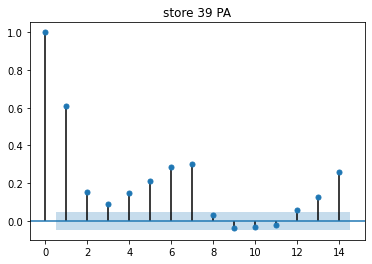

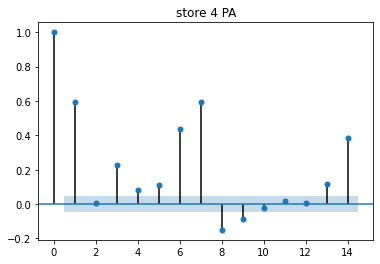

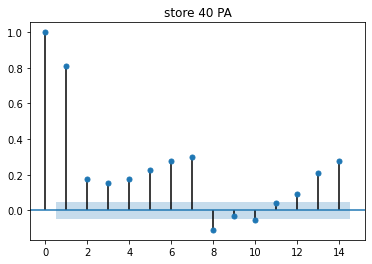

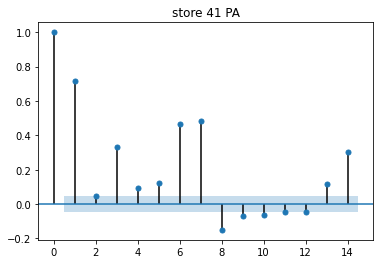

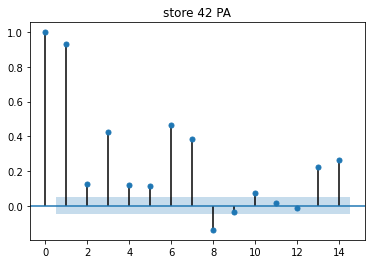

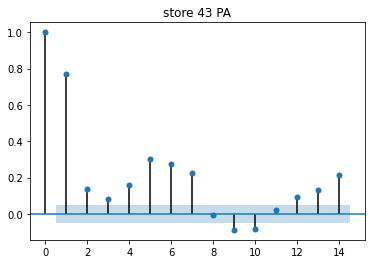

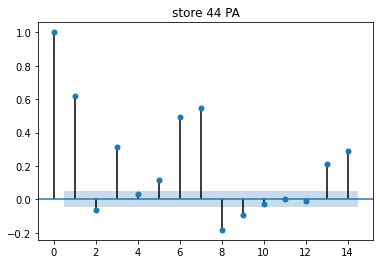

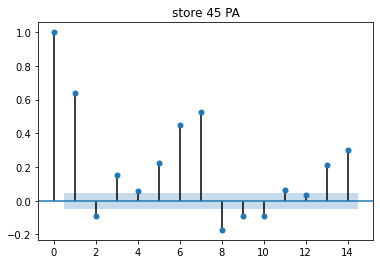

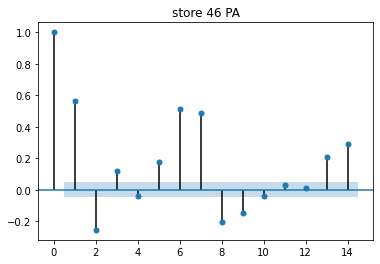

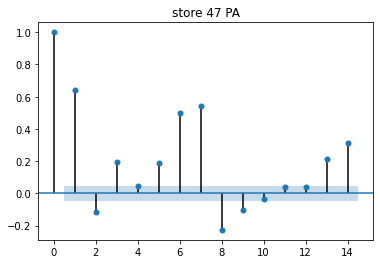

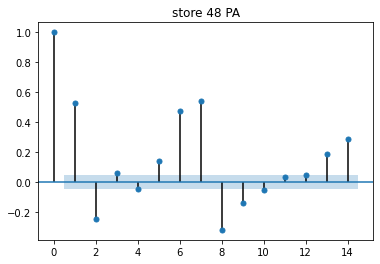

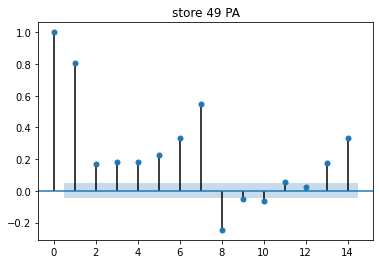

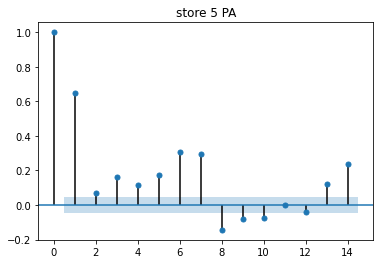

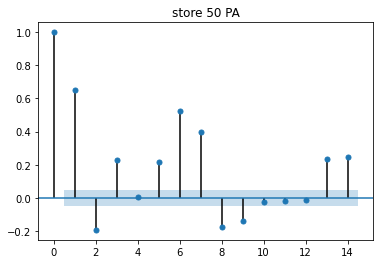

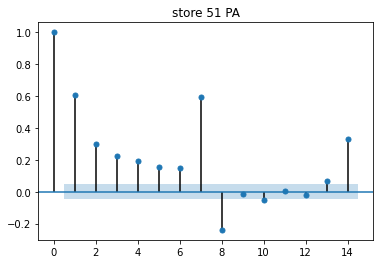

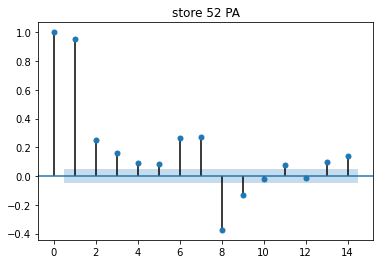

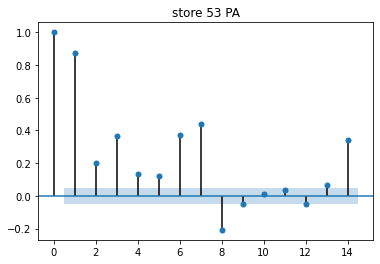

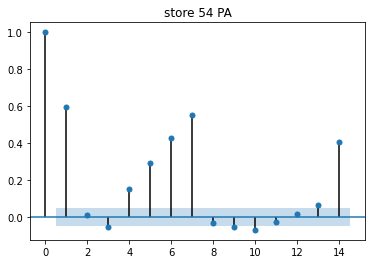

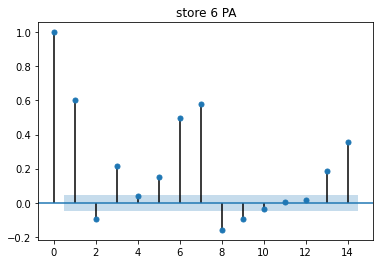

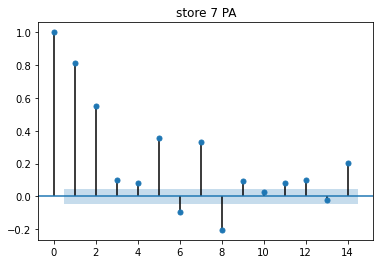

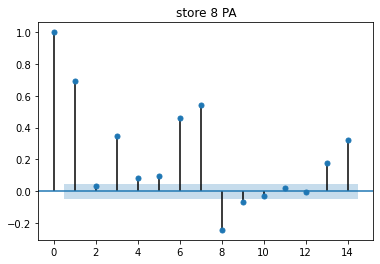

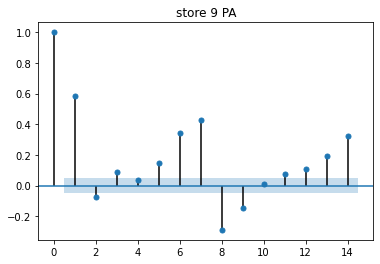

In [ ]:
for i in daily_store_sale_dict.keys():

    ax = statsmodels.graphics.tsaplots.plot_pacf(daily_store_sale_dict[i],lags=14, 
                                                 title = 'store {} PA'.format(i))

In [ ]:
process_train

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0
2013-01-01,1,BABY CARE,0.000,0
2013-01-01,1,BEAUTY,0.000,0
2013-01-01,1,BEVERAGES,0.000,0
2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0
2017-08-15,9,PREPARED FOODS,154.553,1
2017-08-15,9,PRODUCE,2419.729,148


In [ ]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [ ]:
test_data['sales'] = 0
test_data = test_data[['id','date','store_nbr','family','sales','onpromotion']]

test_data

,id,date,store_nbr,family,sales,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0
1,3000889,2017-08-16,1,BABY CARE,0,0
2,3000890,2017-08-16,1,BEAUTY,0,2
3,3000891,2017-08-16,1,BEVERAGES,0,20
4,3000892,2017-08-16,1,BOOKS,0,0
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,0,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0,0
28509,3029397,2017-08-31,9,PRODUCE,0,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,0,9


In [ ]:
process_train['id'] = process_train.reset_index().index

In [ ]:
process_train = process_train.reset_index()
process_train = process_train[['id','date','store_nbr','family','sales','onpromotion']]
process_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [ ]:
merged_train = pd.concat([process_train,test_data])
merged_train = merged_train.set_index(['date','store_nbr','family'])
merged_train

id  sales  onpromotion
date       store_nbr family                                                 
2013-01-01 1         AUTOMOTIVE                        0    0.0            0
                     BABY CARE                         1    0.0            0
                     BEAUTY                            2    0.0            0
                     BEVERAGES                         3    0.0            0
                     BOOKS                             4    0.0            0
...                                                  ...    ...          ...
2017-08-31 9         POULTRY                     3029395    0.0            1
                     PREPARED FOODS              3029396    0.0            0
                     PRODUCE                     3029397    0.0            1
                     SCHOOL AND OFFICE SUPPLIES  3029398    0.0            9
                     SEAFOOD                     3029399    0.0            0

[3029400 rows x 3 columns]

In [ ]:
merged_train

id  sales  onpromotion
date       store_nbr family                                                 
2013-01-01 1         AUTOMOTIVE                        0    0.0            0
                     BABY CARE                         1    0.0            0
                     BEAUTY                            2    0.0            0
                     BEVERAGES                         3    0.0            0
                     BOOKS                             4    0.0            0
...                                                  ...    ...          ...
2017-08-31 9         POULTRY                     3029395    0.0            1
                     PREPARED FOODS              3029396    0.0            0
                     PRODUCE                     3029397    0.0            1
                     SCHOOL AND OFFICE SUPPLIES  3029398    0.0            9
                     SEAFOOD                     3029399    0.0            0

[3029400 rows x 3 columns]

In [ ]:
del test_data
gc.collect()

131

In [ ]:
store_location = store_data.drop(['state','type','cluster'],axis=1)
store_location = store_location.set_index('store_nbr')
store_location = pd.get_dummies(store_location,prefix='store_loc_')
store_location

,store_loc__Ambato,store_loc__Babahoyo,store_loc__Cayambe,store_loc__Cuenca,store_loc__Daule,store_loc__El Carmen,store_loc__Esmeraldas,store_loc__Guaranda,store_loc__Guayaquil,store_loc__Ibarra,...,store_loc__Loja,store_loc__Machala,store_loc__Manta,store_loc__Playas,store_loc__Puyo,store_loc__Quevedo,store_loc__Quito,store_loc__Riobamba,store_loc__Salinas,store_loc__Santo Domingo
store_nbr,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
inputs = merged_train.reset_index().merge(store_location,how='outer',left_on='store_nbr',right_on=store_location.index)
inputs

,date,store_nbr,family,id,sales,onpromotion,store_loc__Ambato,store_loc__Babahoyo,store_loc__Cayambe,store_loc__Cuenca,...,store_loc__Loja,store_loc__Machala,store_loc__Manta,store_loc__Playas,store_loc__Puyo,store_loc__Quevedo,store_loc__Quito,store_loc__Riobamba,store_loc__Salinas,store_loc__Santo Domingo
0,2013-01-01,1,AUTOMOTIVE,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2013-01-01,1,BABY CARE,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2013-01-01,1,BEAUTY,2,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2013-01-01,1,BEVERAGES,3,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2013-01-01,1,BOOKS,4,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,3029395,0.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3029396,2017-08-31,9,PREPARED FOODS,3029396,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3029397,2017-08-31,9,PRODUCE,3029397,0.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,3029398,0.0,9,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
del store_location
del merged_train
gc.collect()

88

In [ ]:
total_sales

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Name: sales, Length: 1684, dtype: float64

In [ ]:
total_sales_to_scale = pd.DataFrame(index=pd.date_range(start='2013-01-01',end='2017-08-31'))
total_sales_to_scale = total_sales_to_scale.merge(total_sales,how='left',left_index=True,right_index=True)
total_sales_to_scale = total_sales_to_scale.rename(columns={'sales':'national_sales'})

In [ ]:
total_sales_to_scale

,national_sales
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229
...,...
2017-08-27,NaN
2017-08-28,NaN
2017-08-29,NaN
2017-08-30,NaN


In [ ]:
from sklearn.preprocessing import MinMaxScaler
mmScale = MinMaxScaler()
mmScale.fit(total_sales_to_scale['national_sales'].to_numpy().reshape(-1,1))

total_sales_to_scale['scaled_nat_sales'] = mmScale.transform(total_sales_to_scale['national_sales'].to_numpy().reshape(-1,1))

In [ ]:
total_sales_to_scale

,national_sales,scaled_nat_sales
2013-01-01,2511.618999,0.000000
2013-01-02,496092.417944,0.337937
2013-01-03,361461.231124,0.245760
2013-01-04,354459.677093,0.240966
2013-01-05,477350.121229,0.325104
...,...,...
2017-08-27,NaN,NaN
2017-08-28,NaN,NaN
2017-08-29,NaN,NaN
2017-08-30,NaN,NaN


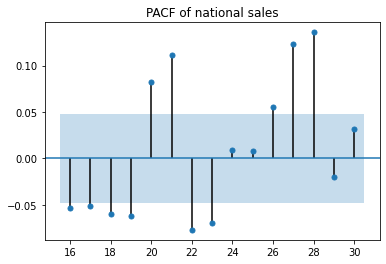

In [ ]:
import  statsmodels.graphics.tsaplots

ax = statsmodels.graphics.tsaplots.plot_pacf(total_sales_to_scale['scaled_nat_sales'].dropna(), 
                                                 lags=range(16,31),
                                                 title = 'PACF of national sales')

In [ ]:
lags= [16,17,18,19,20,21,22,23,24,27,28]
for lag in lags:
    total_sales_to_scale['nat_scaled_sales_lag{}'.format(lag)] = total_sales_to_scale['scaled_nat_sales'].shift(lag)

In [ ]:
total_sales_to_scale = total_sales_to_scale.drop(['national_sales','scaled_nat_sales'],axis=1) 

In [ ]:
total_sales_to_scale.reset_index().tail()

,index,nat_scaled_sales_lag16,nat_scaled_sales_lag17,nat_scaled_sales_lag18,nat_scaled_sales_lag19,nat_scaled_sales_lag20,nat_scaled_sales_lag21,nat_scaled_sales_lag22,nat_scaled_sales_lag23,nat_scaled_sales_lag24,nat_scaled_sales_lag27,nat_scaled_sales_lag28
1699,2017-08-27,0.564068,0.444261,0.500919,0.489709,0.544275,0.716875,0.659455,0.565028,0.496762,0.604794,0.767672
1700,2017-08-28,0.540965,0.564068,0.444261,0.500919,0.489709,0.544275,0.716875,0.659455,0.565028,0.675089,0.604794
1701,2017-08-29,0.590952,0.540965,0.564068,0.444261,0.500919,0.489709,0.544275,0.716875,0.659455,0.658783,0.675089
1702,2017-08-30,0.519256,0.590952,0.540965,0.564068,0.444261,0.500919,0.489709,0.544275,0.716875,0.496762,0.658783
1703,2017-08-31,0.520447,0.519256,0.590952,0.540965,0.564068,0.444261,0.500919,0.489709,0.544275,0.565028,0.496762


In [ ]:
inputs = inputs.merge(total_sales_to_scale.reset_index(),how='left',left_on='date',right_on='index')

In [ ]:
del total_sales_to_scale

In [ ]:
inputs.columns

Index(['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'store_loc__Ambato', 'store_loc__Babahoyo', 'store_loc__Cayambe',
       'store_loc__Cuenca', 'store_loc__Daule', 'store_loc__El Carmen',
       'store_loc__Esmeraldas', 'store_loc__Guaranda', 'store_loc__Guayaquil',
       'store_loc__Ibarra', 'store_loc__Latacunga', 'store_loc__Libertad',
       'store_loc__Loja', 'store_loc__Machala', 'store_loc__Manta',
       'store_loc__Playas', 'store_loc__Puyo', 'store_loc__Quevedo',
       'store_loc__Quito', 'store_loc__Riobamba', 'store_loc__Salinas',
       'store_loc__Santo Domingo', 'index', 'nat_scaled_sales_lag16',
       'nat_scaled_sales_lag17', 'nat_scaled_sales_lag18',
       'nat_scaled_sales_lag19', 'nat_scaled_sales_lag20',
       'nat_scaled_sales_lag21', 'nat_scaled_sales_lag22',
       'nat_scaled_sales_lag23', 'nat_scaled_sales_lag24',
       'nat_scaled_sales_lag27', 'nat_scaled_sales_lag28'],
      dtype='object')

In [ ]:
inputs.drop(['index'],axis=1,inplace=True)

In [ ]:
inputs

,date,store_nbr,family,id,sales,onpromotion,store_loc__Ambato,store_loc__Babahoyo,store_loc__Cayambe,store_loc__Cuenca,...,nat_scaled_sales_lag17,nat_scaled_sales_lag18,nat_scaled_sales_lag19,nat_scaled_sales_lag20,nat_scaled_sales_lag21,nat_scaled_sales_lag22,nat_scaled_sales_lag23,nat_scaled_sales_lag24,nat_scaled_sales_lag27,nat_scaled_sales_lag28
0,2013-01-01,1,AUTOMOTIVE,0,0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,1,0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,2,0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,3,0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,4,0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,3029395,0.0,1,0,0,0,0,...,0.519256,0.590952,0.540965,0.564068,0.444261,0.500919,0.489709,0.544275,0.565028,0.496762
3029396,2017-08-31,9,PREPARED FOODS,3029396,0.0,0,0,0,0,0,...,0.519256,0.590952,0.540965,0.564068,0.444261,0.500919,0.489709,0.544275,0.565028,0.496762
3029397,2017-08-31,9,PRODUCE,3029397,0.0,1,0,0,0,0,...,0.519256,0.590952,0.540965,0.564068,0.444261,0.500919,0.489709,0.544275,0.565028,0.496762
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,3029398,0.0,9,0,0,0,0,...,0.519256,0.590952,0.540965,0.564068,0.444261,0.500919,0.489709,0.544275,0.565028,0.496762


In [ ]:
lags = [1, 2, 3, 4, 5, 6, 7, 8, 13, 14]
for lag in lags:
    inputs['store_fam_sales_lag_{}'.format(lag)] = inputs['sales'].shift(lag)

In [ ]:
inputs.columns

Index(['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'store_loc__Ambato', 'store_loc__Babahoyo', 'store_loc__Cayambe',
       'store_loc__Cuenca', 'store_loc__Daule', 'store_loc__El Carmen',
       'store_loc__Esmeraldas', 'store_loc__Guaranda', 'store_loc__Guayaquil',
       'store_loc__Ibarra', 'store_loc__Latacunga', 'store_loc__Libertad',
       'store_loc__Loja', 'store_loc__Machala', 'store_loc__Manta',
       'store_loc__Playas', 'store_loc__Puyo', 'store_loc__Quevedo',
       'store_loc__Quito', 'store_loc__Riobamba', 'store_loc__Salinas',
       'store_loc__Santo Domingo', 'nat_scaled_sales_lag16',
       'nat_scaled_sales_lag17', 'nat_scaled_sales_lag18',
       'nat_scaled_sales_lag19', 'nat_scaled_sales_lag20',
       'nat_scaled_sales_lag21', 'nat_scaled_sales_lag22',
       'nat_scaled_sales_lag23', 'nat_scaled_sales_lag24',
       'nat_scaled_sales_lag27', 'nat_scaled_sales_lag28',
       'store_fam_sales_lag_1', 'store_fam_sales_lag_2',
       'sto

In [ ]:
transactions

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922
...,...,...
2017-08-15,50,2804
2017-08-15,51,1573
2017-08-15,52,2255


In [ ]:
store_nbr = range(1,55)
dates = pd.date_range('2013-01-01','2017-08-31')
mul_index = pd.MultiIndex.from_product([dates,store_nbr],names=['date','store_nbr'])
df = pd.DataFrame(index=mul_index)

In [ ]:
df.reset_index()

,date,store_nbr
0,2013-01-01,1
1,2013-01-01,2
2,2013-01-01,3
3,2013-01-01,4
4,2013-01-01,5
...,...,...
92011,2017-08-31,50
92012,2017-08-31,51
92013,2017-08-31,52
92014,2017-08-31,53


In [ ]:
transactions.reset_index()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [ ]:
df_transaction = df.reset_index().merge(transactions.reset_index(),
                                        how='left',
                                        left_on=['date','store_nbr'],
                                        right_on=['date','store_nbr']
                                       )

In [ ]:
df_transaction.fillna(0, inplace=True)

In [ ]:
df_transaction.loc[30020:30026]

,date,store_nbr,transactions
30020,2014-07-10,51,1552.0
30021,2014-07-10,52,0.0
30022,2014-07-10,53,657.0
30023,2014-07-10,54,750.0
30024,2014-07-11,1,1802.0
30025,2014-07-11,2,1962.0
30026,2014-07-11,3,3138.0


In [ ]:
df_transaction

,date,store_nbr,transactions
0,2013-01-01,1,0.0
1,2013-01-01,2,0.0
2,2013-01-01,3,0.0
3,2013-01-01,4,0.0
4,2013-01-01,5,0.0
...,...,...,...
92011,2017-08-31,50,0.0
92012,2017-08-31,51,0.0
92013,2017-08-31,52,0.0
92014,2017-08-31,53,0.0


In [ ]:
lags = [21,22,28]
for lag in lags:
    df_transaction['trans_lag_{}'.format(lag)] = df_transaction['transactions'].shift(lag)

In [ ]:
df_transaction = df_transaction.drop('transactions',axis=1)

In [ ]:
df_transaction = df_transaction.fillna(0)

In [ ]:
df_transaction.loc[30030:30040]

,date,store_nbr,trans_lag_21,trans_lag_22,trans_lag_28
30030,2014-07-11,7,1207.0,1348.0,1019.0
30031,2014-07-11,8,888.0,1207.0,2279.0
30032,2014-07-11,9,0.0,888.0,593.0
30033,2014-07-11,10,1209.0,0.0,947.0
30034,2014-07-11,11,3780.0,1209.0,1551.0
30035,2014-07-11,12,3143.0,3780.0,1477.0
30036,2014-07-11,13,3018.0,3143.0,1348.0
30037,2014-07-11,14,3312.0,3018.0,1207.0
30038,2014-07-11,15,2471.0,3312.0,888.0
30039,2014-07-11,16,2219.0,2471.0,0.0


In [ ]:
inputs

,date,store_nbr,family,id,sales,onpromotion,store_loc__Ambato,store_loc__Babahoyo,store_loc__Cayambe,store_loc__Cuenca,...,store_fam_sales_lag_1,store_fam_sales_lag_2,store_fam_sales_lag_3,store_fam_sales_lag_4,store_fam_sales_lag_5,store_fam_sales_lag_6,store_fam_sales_lag_7,store_fam_sales_lag_8,store_fam_sales_lag_13,store_fam_sales_lag_14
0,2013-01-01,1,AUTOMOTIVE,0,0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,1,0.0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,2,0.0,0,0,0,0,0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,3,0.0,0,0,0,0,0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,4,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,3029395,0.0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3029396,2017-08-31,9,PREPARED FOODS,3029396,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3029397,2017-08-31,9,PRODUCE,3029397,0.0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,3029398,0.0,9,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
inputs = inputs.merge(df_transaction, how='left', left_on = ['date','store_nbr'],right_on = ['date','store_nbr'])

In [ ]:
inputs

,date,store_nbr,family,id,sales,onpromotion,store_loc__Ambato,store_loc__Babahoyo,store_loc__Cayambe,store_loc__Cuenca,...,store_fam_sales_lag_4,store_fam_sales_lag_5,store_fam_sales_lag_6,store_fam_sales_lag_7,store_fam_sales_lag_8,store_fam_sales_lag_13,store_fam_sales_lag_14,trans_lag_21,trans_lag_22,trans_lag_28
0,2013-01-01,1,AUTOMOTIVE,0,0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,2013-01-01,1,BABY CARE,1,0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,2013-01-01,1,BEAUTY,2,0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,2013-01-01,1,BEVERAGES,3,0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,2013-01-01,1,BOOKS,4,0.0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,3029395,0.0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3029396,2017-08-31,9,PREPARED FOODS,3029396,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3029397,2017-08-31,9,PRODUCE,3029397,0.0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,3029398,0.0,9,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
calendar_checkpoint.reset_index().tail()

,index,holiday__Ambato,holiday__Cayambe,holiday__Cotopaxi,holiday__Cuenca,holiday__Ecuador,holiday__El Carmen,holiday__Esmeraldas,holiday__Guaranda,holiday__Guayaquil,...,holiday__Santo Domingo de los Tsachilas,type,locale,transferred,dow,workday,is_football,is_eq,is_ny,is_christmas
1699,2017-08-27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7,0,0,0,0,0
1700,2017-08-28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1701,2017-08-29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,1,0,0,0,0
1702,2017-08-30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,1,0,0,0,0
1703,2017-08-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,1,0,0,0,0


In [ ]:
inputs = inputs.merge(calendar_checkpoint,how='left',left_on=['date'],right_on=calendar_checkpoint.index)

In [ ]:
inputs.columns

Index(['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'store_loc__Ambato', 'store_loc__Babahoyo', 'store_loc__Cayambe',
       'store_loc__Cuenca', 'store_loc__Daule', 'store_loc__El Carmen',
       'store_loc__Esmeraldas', 'store_loc__Guaranda', 'store_loc__Guayaquil',
       'store_loc__Ibarra', 'store_loc__Latacunga', 'store_loc__Libertad',
       'store_loc__Loja', 'store_loc__Machala', 'store_loc__Manta',
       'store_loc__Playas', 'store_loc__Puyo', 'store_loc__Quevedo',
       'store_loc__Quito', 'store_loc__Riobamba', 'store_loc__Salinas',
       'store_loc__Santo Domingo', 'nat_scaled_sales_lag16',
       'nat_scaled_sales_lag17', 'nat_scaled_sales_lag18',
       'nat_scaled_sales_lag19', 'nat_scaled_sales_lag20',
       'nat_scaled_sales_lag21', 'nat_scaled_sales_lag22',
       'nat_scaled_sales_lag23', 'nat_scaled_sales_lag24',
       'nat_scaled_sales_lag27', 'nat_scaled_sales_lag28',
       'store_fam_sales_lag_1', 'store_fam_sales_lag_2',
       'sto

In [ ]:
pd.set_option('display.max_rows',None)
inputs.isna().sum()

date                                           0
store_nbr                                      0
family                                         0
id                                             0
sales                                          0
onpromotion                                    0
store_loc__Ambato                              0
store_loc__Babahoyo                            0
store_loc__Cayambe                             0
store_loc__Cuenca                              0
store_loc__Daule                               0
store_loc__El Carmen                           0
store_loc__Esmeraldas                          0
store_loc__Guaranda                            0
store_loc__Guayaquil                           0
store_loc__Ibarra                              0
store_loc__Latacunga                           0
store_loc__Libertad                            0
store_loc__Loja                                0
store_loc__Machala                             0
store_loc__Manta    

In [ ]:
pd.reset_option('display.max_rows','display.max_columns')

In [ ]:
inputs.dropna(inplace = True)
inputs.isna().sum().sum()

0

In [ ]:
inputs = inputs.set_index('date')

In [ ]:
inputs.tail()

,store_nbr,family,id,sales,onpromotion,store_loc__Ambato,store_loc__Babahoyo,store_loc__Cayambe,store_loc__Cuenca,store_loc__Daule,...,holiday__Santo Domingo de los Tsachilas,type,locale,transferred,dow,workday,is_football,is_eq,is_ny,is_christmas
date,,,,,,,,,,,,,,,,,,,,,
2017-08-31,9,POULTRY,3029395,0.0,1,0,0,0,0,0,...,0,0,0,0,4,1,0,0,0,0
2017-08-31,9,PREPARED FOODS,3029396,0.0,0,0,0,0,0,0,...,0,0,0,0,4,1,0,0,0,0
2017-08-31,9,PRODUCE,3029397,0.0,1,0,0,0,0,0,...,0,0,0,0,4,1,0,0,0,0
2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,3029398,0.0,9,0,0,0,0,0,...,0,0,0,0,4,1,0,0,0,0
2017-08-31,9,SEAFOOD,3029399,0.0,0,0,0,0,0,0,...,0,0,0,0,4,1,0,0,0,0


In [ ]:
y_train = inputs.loc['2013-01-01':'2017-08-15', 'sales']
y_train.tail()

date
2017-08-15     438.133
2017-08-15     154.553
2017-08-15    2419.729
2017-08-15     121.000
2017-08-15      16.000
Name: sales, dtype: float64

In [ ]:
x_train = inputs.loc['2013-01-01':'2017-08-15'].drop(['sales','id'],axis=1)
x_train = x_train.reset_index()
x_train = x_train.set_index(['date','store_nbr','family'])

In [ ]:
x_train.tail()

onpromotion  \
date       store_nbr family                                    
2017-08-15 9         POULTRY                               0   
                     PREPARED FOODS                        1   
                     PRODUCE                             148   
                     SCHOOL AND OFFICE SUPPLIES            8   
                     SEAFOOD                               0   

                                                 store_loc__Ambato  \
date       store_nbr family                                          
2017-08-15 9         POULTRY                                     0   
                     PREPARED FOODS                              0   
                     PRODUCE                                     0   
                     SCHOOL AND OFFICE SUPPLIES                  0   
                     SEAFOOD                                     0   

                                                 store_loc__Babahoyo  \
date       store_nbr family                                            
2017-08-15 9         POULTRY                                       0   
                     PREPARED FOODS                                0   
                     PRODUCE                                       0   
                     SCHOOL AND OFFICE SUPPLIES                    0   
                     SEAFOOD                                       0   

                                                 store_loc__Cayambe  \
date       store_nbr family                                           
2017-08-15 9         POULTRY                                      0   
                     PREPARED FOODS                               0   
                     PRODUCE                                      0   
                     SCHOOL AND OFFICE SUPPLIES                   0   
                     SEAFOOD                                      0   

                                                 store_loc__Cuenca  \
date       store_nbr family                                          
2017-08-15 9         POULTRY                                     0   
                     PREPARED FOODS                              0   
                     PRODUCE                                     0   
                     SCHOOL AND OFFICE SUPPLIES                  0   
                     SEAFOOD                                     0   

                                                 store_loc__Daule  \
date       store_nbr family                                         
2017-08-15 9         POULTRY                                    0   
                     PREPARED FOODS                             0   
                     PRODUCE                                    0   
                     SCHOOL AND OFFICE SUPPLIES                 0   
                     SEAFOOD                                    0   

                                                 store_loc__El Carmen  \
date       store_nbr family                                             
2017-08-15 9         POULTRY                                        0   
                     PREPARED FOODS                                 0   
                     PRODUCE                                        0   
                     SCHOOL AND OFFICE SUPPLIES                     0   
                     SEAFOOD                                        0   

                                                 store_loc__Esmeraldas  \
date       store_nbr family                                              
2017-08-15 9         POULTRY                                         0   
                     PREPARED FOODS                                  0   
                     PRODUCE                                         0   
                     SCHOOL AND OFFICE SUPPLIES                      0   
                     SEAFOOD                                         0   

                                                 store_loc__Guaranda  \
date       store_nbr family 

In [ ]:
x_train.describe()

,onpromotion,store_loc__Ambato,store_loc__Babahoyo,store_loc__Cayambe,store_loc__Cuenca,store_loc__Daule,store_loc__El Carmen,store_loc__Esmeraldas,store_loc__Guaranda,store_loc__Guayaquil,...,holiday__Santa Elena,holiday__Santo Domingo,holiday__Santo Domingo de los Tsachilas,transferred,dow,workday,is_football,is_eq,is_ny,is_christmas
count,2.872584e+06,2.872584e+06,2.872584e+06,2.872584e+06,2.872584e+06,2.872584e+06,2.872584e+06,2.872584e+06,2.872584e+06,2.872584e+06,...,2.872584e+06,2872584.0,2.872584e+06,2.872584e+06,2.872584e+06,2.872584e+06,2.872584e+06,2.872584e+06,2.872584e+06,2872584.0
mean,2.650192e+00,3.703704e-02,1.851852e-02,1.851852e-02,5.555556e-02,1.851852e-02,1.851852e-02,1.851852e-02,1.851852e-02,1.481481e-01,...,2.481390e-03,0.0,2.481390e-03,4.962779e-03,3.992556e+00,6.830025e-01,8.684864e-03,1.799007e-02,2.481390e-03,0.0
std,1.234626e+01,1.888526e-01,1.348169e-01,1.348169e-01,2.290615e-01,1.348169e-01,1.348169e-01,1.348169e-01,1.348169e-01,3.552468e-01,...,4.975172e-02,0.0,4.975172e-02,7.027198e-02,2.001227e+00,4.653065e-01,9.278707e-02,1.329152e-01,4.975172e-02,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
max,7.410000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,0.0,1.000000e+00,1.000000e+00,7.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0


In [ ]:
x_test = inputs.loc['2017-08-16': ]
test_id = x_test['id'] #Keep for later

x_test.drop(['sales','id'],axis = 1,inplace = True)

x_test = x_test.reset_index()
x_test = x_test.set_index(['date','store_nbr','family'])
x_test

onpromotion  \
date       store_nbr family                                    
2017-08-16 1         AUTOMOTIVE                            0   
                     BABY CARE                             0   
                     BEAUTY                                2   
                     BEVERAGES                            20   
                     BOOKS                                 0   
...                                                      ...   
2017-08-31 9         POULTRY                               1   
                     PREPARED FOODS                        0   
                     PRODUCE                               1   
                     SCHOOL AND OFFICE SUPPLIES            9   
                     SEAFOOD                               0   

                                                 store_loc__Ambato  \
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                                  0   
                     BABY CARE                                   0   
                     BEAUTY                                      0   
                     BEVERAGES                                   0   
                     BOOKS                                       0   
...                                                            ...   
2017-08-31 9         POULTRY                                     0   
                     PREPARED FOODS                              0   
                     PRODUCE                                     0   
                     SCHOOL AND OFFICE SUPPLIES                  0   
                     SEAFOOD                                     0   

                                                 store_loc__Babahoyo  \
date       store_nbr family                                            
2017-08-16 1         AUTOMOTIVE                                    0   
                     BABY CARE                                     0   
                     BEAUTY                                        0   
                     BEVERAGES                                     0   
                     BOOKS                                         0   
...                                                              ...   
2017-08-31 9         POULTRY                                       0   
                     PREPARED FOODS                                0   
                     PRODUCE                                       0   
                     SCHOOL AND OFFICE SUPPLIES                    0   
                     SEAFOOD                                       0   

                                                 store_loc__Cayambe  \
date       store_nbr family                                           
2017-08-16 1         AUTOMOTIVE                                   0   
                     BABY CARE                                    0   
                     BEAUTY                                       0   
                     BEVERAGES                                    0   
                     BOOKS                                        0   
...                                                             ...   
2017-08-31 9         POULTRY                                      0   
                     PREPARED FOODS                               0   
                     PRODUCE                                      0   
                     SCHOOL AND OFFICE SUPPLIES                   0   
                     SEAFOOD                                      0   

                                                 store_loc__Cuenca  \
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                                  0   
                     BABY CARE                                   0   
                     BEAUTY                                      0   
                     BEVERAGES                                   0   
                     BOO

In [ ]:
sample

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [ ]:
test_id

date
2017-08-16    3000888
2017-08-16    3000889
2017-08-16    3000890
2017-08-16    3000891
2017-08-16    3000892
               ...   
2017-08-31    3029395
2017-08-31    3029396
2017-08-31    3029397
2017-08-31    3029398
2017-08-31    3029399
Name: id, Length: 28512, dtype: int64

In [ ]:
sample.to_csv('submissiontoday.csv', index = False)